In [22]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [73]:
prefix = "../final"

In [74]:
def update_fontsize(size=12):
    mp.rcParams.update({'font.size': size})

In [75]:
SOCK_NAMES = ['throughput', 'latency']
CPU_NAMES = ['timestamp', 'wait', 'used', 'core', 'comm']
SPIN_NAMES=['decrypt_worker', 'decrypt_packet', 'spinlock']
def import_data(path, n_clients=100):
    
    # Import throughput and latency data
    df = pd.read_csv(f"{path}/sock-{n_clients}.csv", names=SOCK_NAMES)
   
    # Import CPU data
    cpu_df = pd.read_csv(f"{path}/cpu-{n_clients}.csv", names=CPU_NAMES)
    num_pids = len(cpu_df.comm.unique())
    tmp = cpu_df.groupby(['timestamp', 'core']).sum(numeric_only=True).reset_index()
    tmp = tmp.groupby('core').median(numeric_only=True).mean()
    df['cpu'] = tmp['used']
    df['num_pids'] = num_pids

    # Import lock data
    wg_df = pd.read_csv(f"{path}/wg-{n_clients}.csv", names=SPIN_NAMES)

    # Import micro data
    micro_df = pd.read_csv(f"{path}/micro-{n_clients}.csv")
    
    df = pd.concat([df, wg_df, micro_df], axis=1)
    return df

In [76]:
benchmarks = os.listdir(prefix)
variants = {'-'.join(name.split('-')[2:]).upper().replace('-POOL', ''): name for name in benchmarks}

variants

{'VANILLA': 'benchmark-wireguard-vanilla',
 'MULTI-QUEUE': 'benchmark-wireguard-multi-queue-pool',
 'NO-QUEUE': 'benchmark-wireguard-no-queue',
 'MULTI-QUEUE-STEERING': 'benchmark-wireguard-multi-queue-pool-steering',
 'BATCH': 'benchmark-wireguard-batch'}

In [77]:
dfs = {}

# Import Vanilla

In [78]:
bench = 'VANILLA'
path = f"{prefix}/{variants[bench]}/summary"
df = import_data(path)
df['variant'] = 'SSRB'
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']

dfs[bench] = df
df_vanilla = df

In [79]:
df_vanilla

,throughput,latency,cpu,num_pids,decrypt_worker,decrypt_packet,spinlock,cache_miss,cache_ops,context_switch,...,start,end,variant,duration,cache_miss_ratio,l1_ratio,llc_ratio,migrations/s,cs/s,faults/s
0,18.490017,154.374,94.789474,370,78.62,133.5,1.12,32230,44830,81847,...,1230.50426,1235.523658,SSRB,5.019398,0.718938,0.997748,0.855767,686.73574,16306.138704,10.957489


# Import No queue

In [80]:
bench = 'NO-QUEUE'
path = f"{prefix}/{variants[bench]}/summary"
df = import_data(path)
df['variant'] = "NRB"
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
dfs[bench] = df
df_nq = df
df_nq['spinlock'] = 0.1

# Import Batch

In [81]:
bench = 'BATCH'
path = f"{prefix}/{variants[bench]}/summary"

batches = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])
df = []
for batch in batches:
    path_batch = f"{path}/batch-{batch}/ring-1"
    tmp = import_data(path_batch)
    tmp['batch'] = batch
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = "SSRB-BC"
dfs[bench] = df
df_batch = df

# Import MRB

In [82]:
bench = 'MULTI-QUEUE'
path = f"{prefix}/{variants[bench]}/summary/batch-1"

rings = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])

df = []
for ring in rings:
    path_ring = f"{path}/ring-{ring}"
    tmp = import_data(path_ring)
    tmp['ring'] = ring
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = 'MRB'
dfs[bench] = df
df_mrb = df

# MRB-Steering

In [83]:
bench = 'MULTI-QUEUE-STEERING'
path = f"{prefix}/{variants[bench]}/summary/batch-1"

rings = sorted([int(i.split('-')[-1]) for i in os.listdir(path)])

df = []
for ring in rings:
    path_ring = f"{path}/ring-{ring}"
    tmp = import_data(path_ring)
    tmp['ring'] = ring
    df.append(tmp)
df = pd.concat(df, axis=0)
df['throughput'] /= 1000
df['latency'] /= 1000
df['duration'] = df['end'] - df['start']
df["cache_miss_ratio"] = df['cache_miss'] / df['cache_ops']
df['l1_ratio'] = df['l1_miss'] / df['l1_ops']
df['llc_ratio'] = df['llc_miss'] / df['llc_ops']
df['migrations/s'] = df['migrations'] / df['duration']
df['cs/s'] = df['context_switch'] / df['duration']
df['faults/s'] = df['faults'] / df['duration']
df['variant'] = 'MRB'
dfs[bench] = df
df_mrb_str = df

In [84]:
def plot_(df, x, y, xlabel, ylabel, fontsize=16, ylim=None, normal_value=None, text_offset=0, text_spacing=1, savefig=None):
    with plt.style.context(['science', 'ieee']):
        update_fontsize(fontsize)
        ax = df.plot.bar(x=x, y=y, ylim=ylim,
                         ylabel=ylabel,legend=None,
                        xlabel=xlabel, grid=True,
                         )
        if normal_value is not None:
            ax.axhline(y=normal_value, color='red', linestyle='--', label='vanilla')
            ax.annotate(
                f'VANILLA', 
                xy=(2, normal_value), 
                xytext=(text_offset, normal_value+text_spacing), color='red'
            )
        plt.xticks(rotation=0)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        else:
            plt.show()

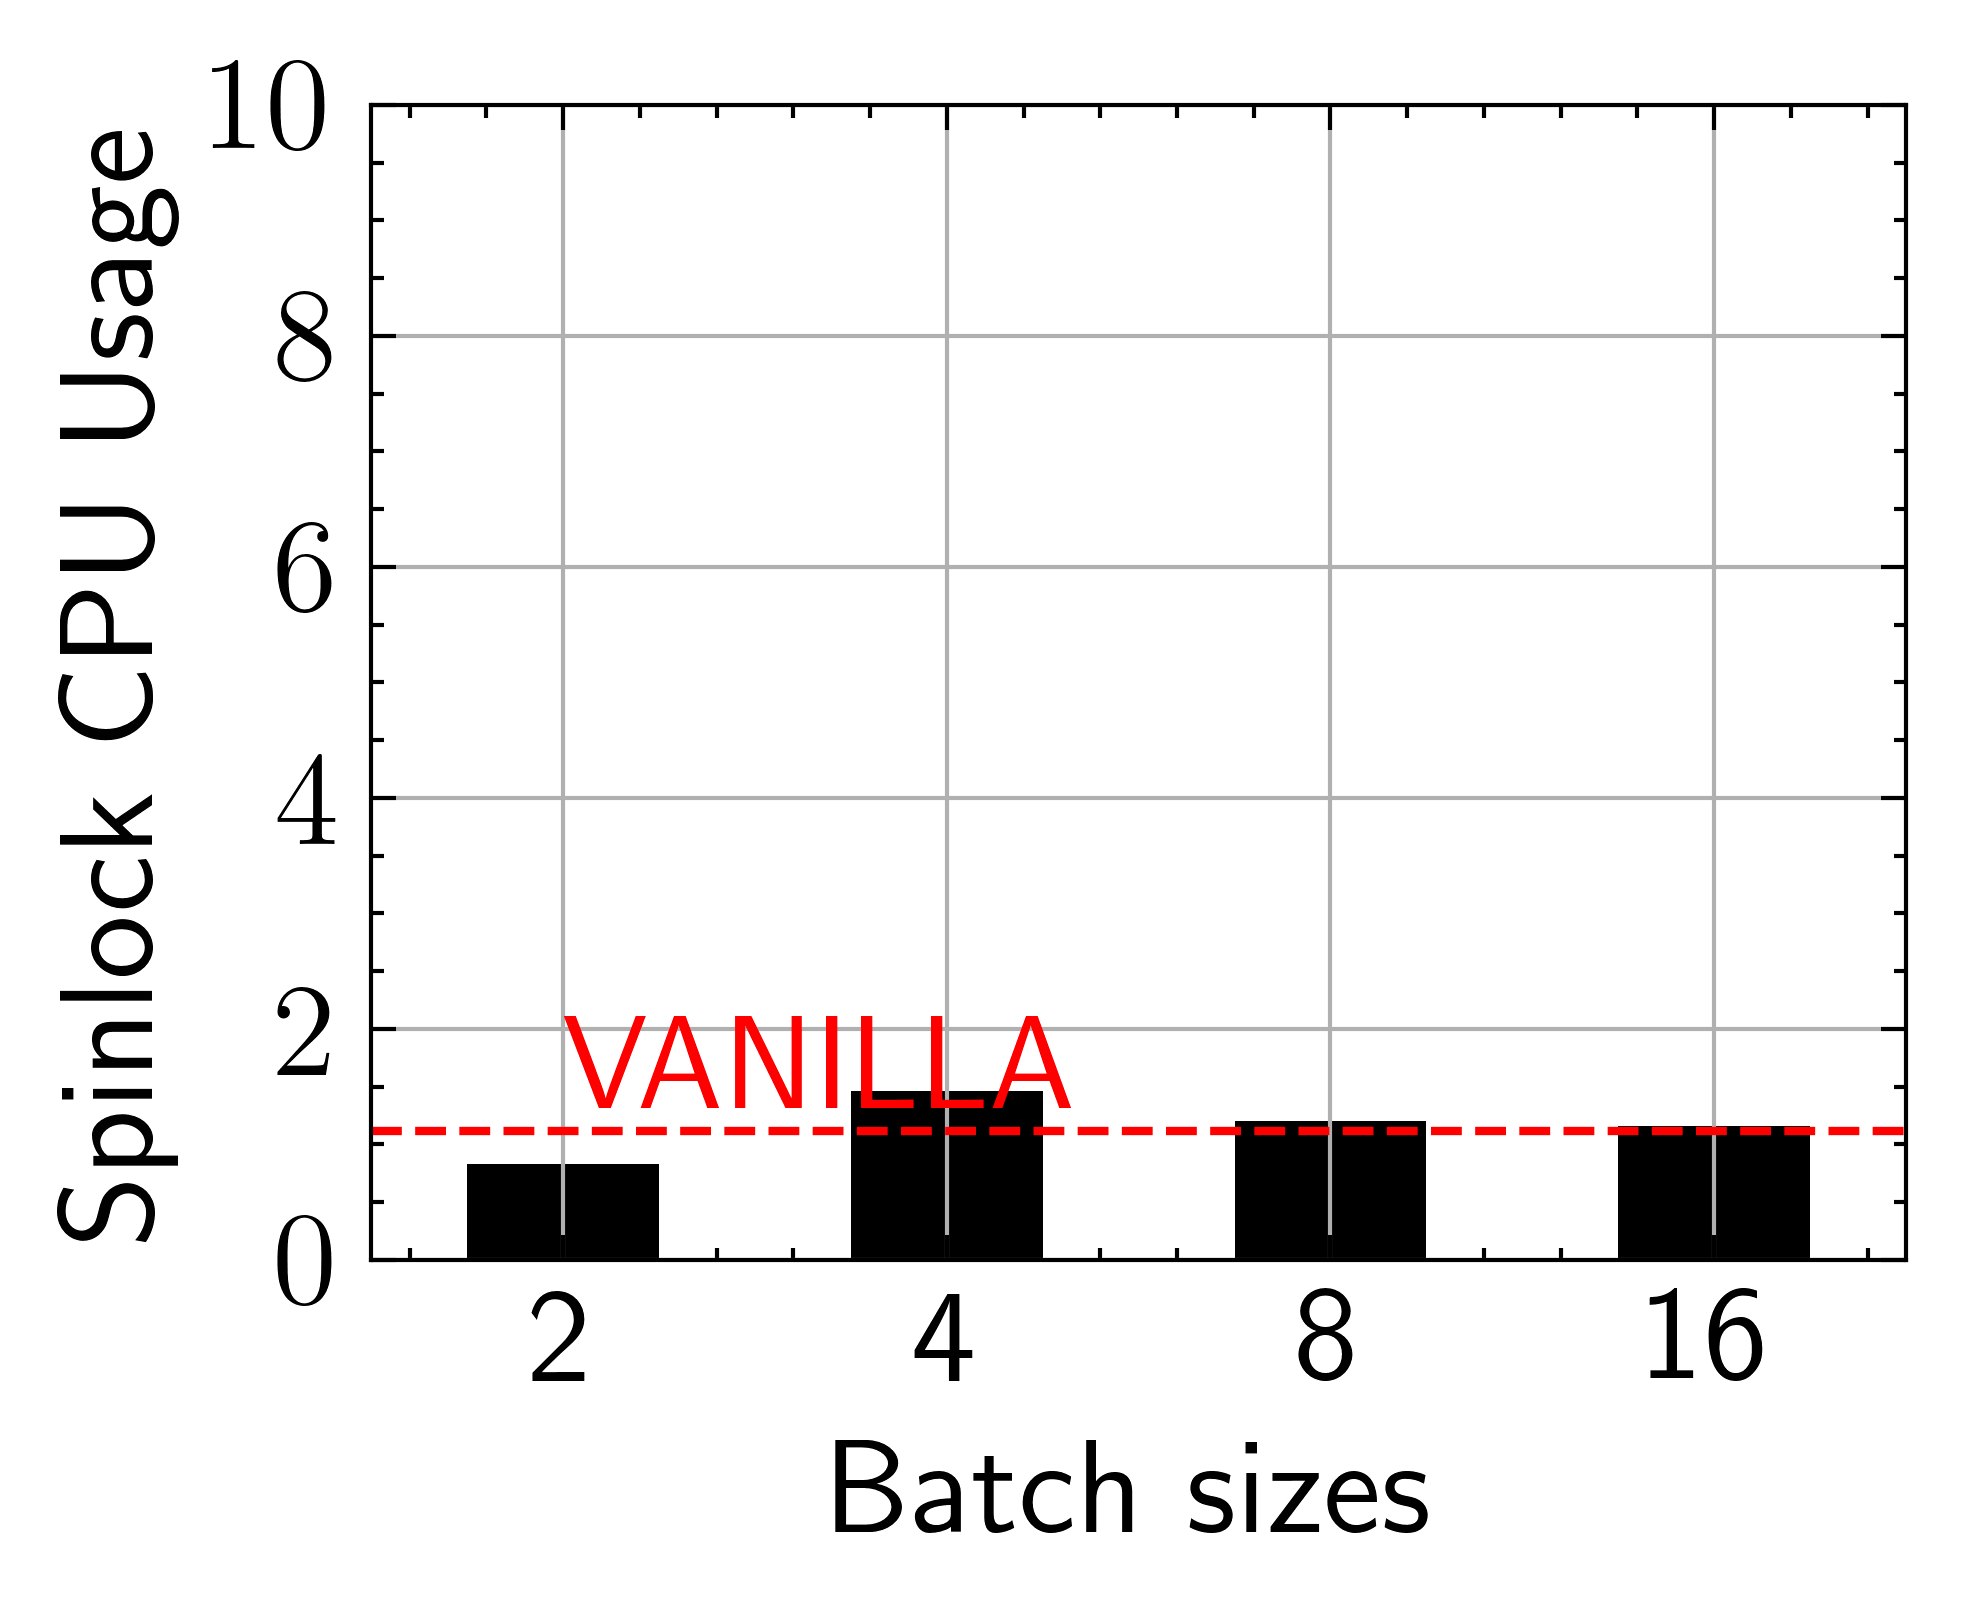

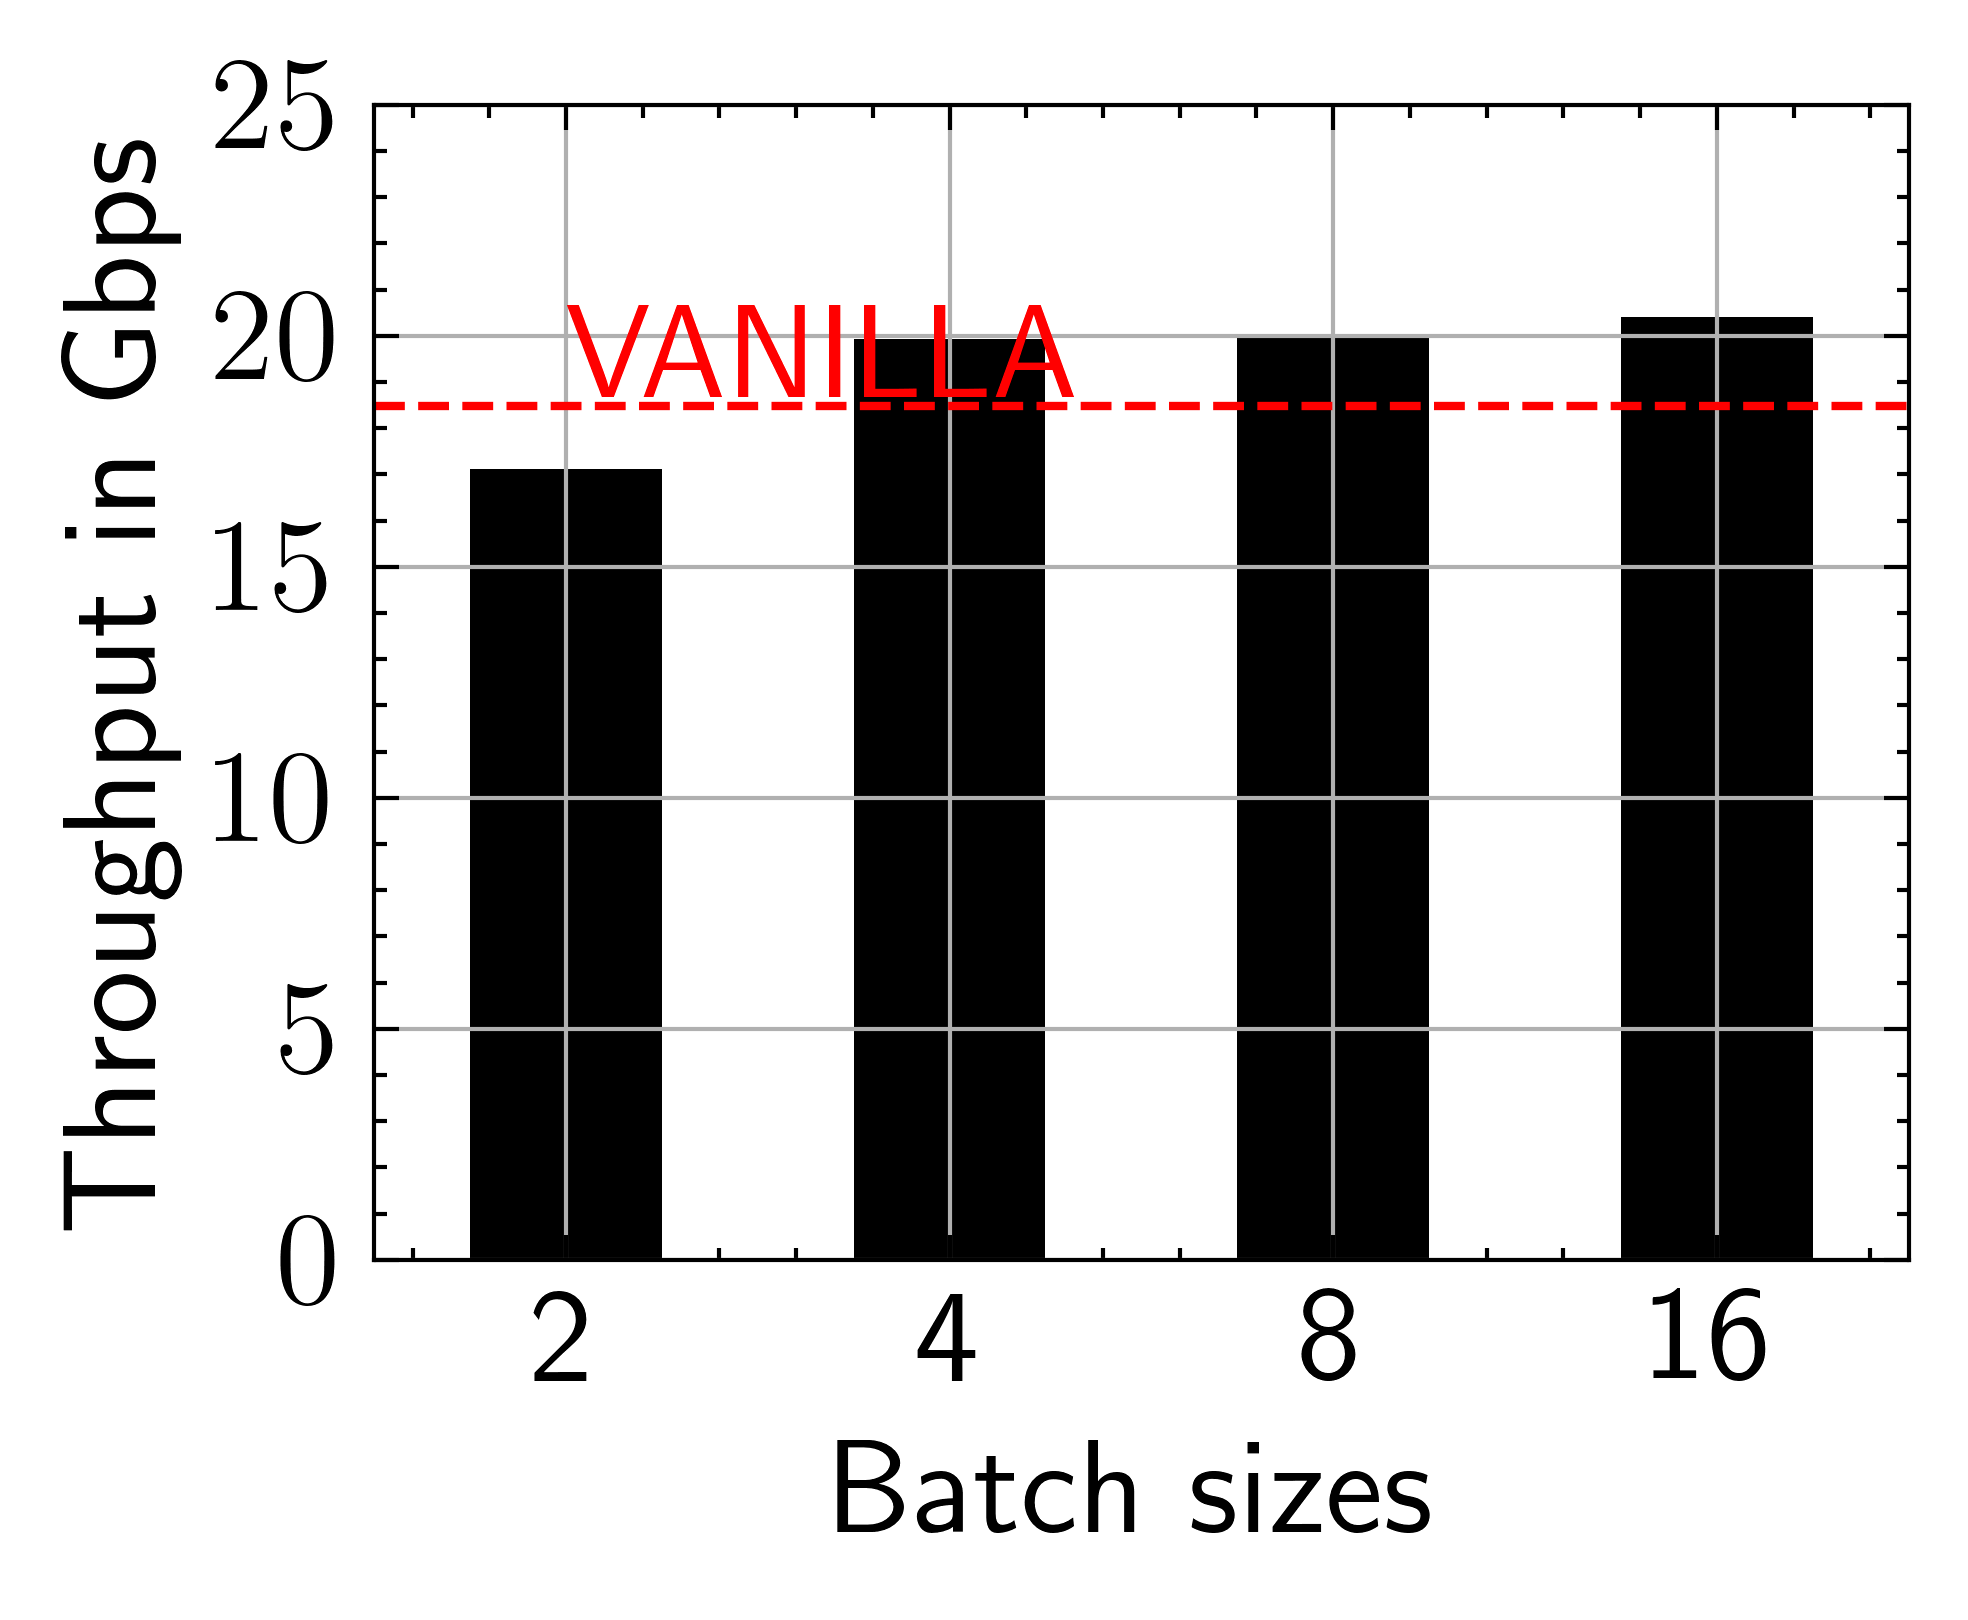

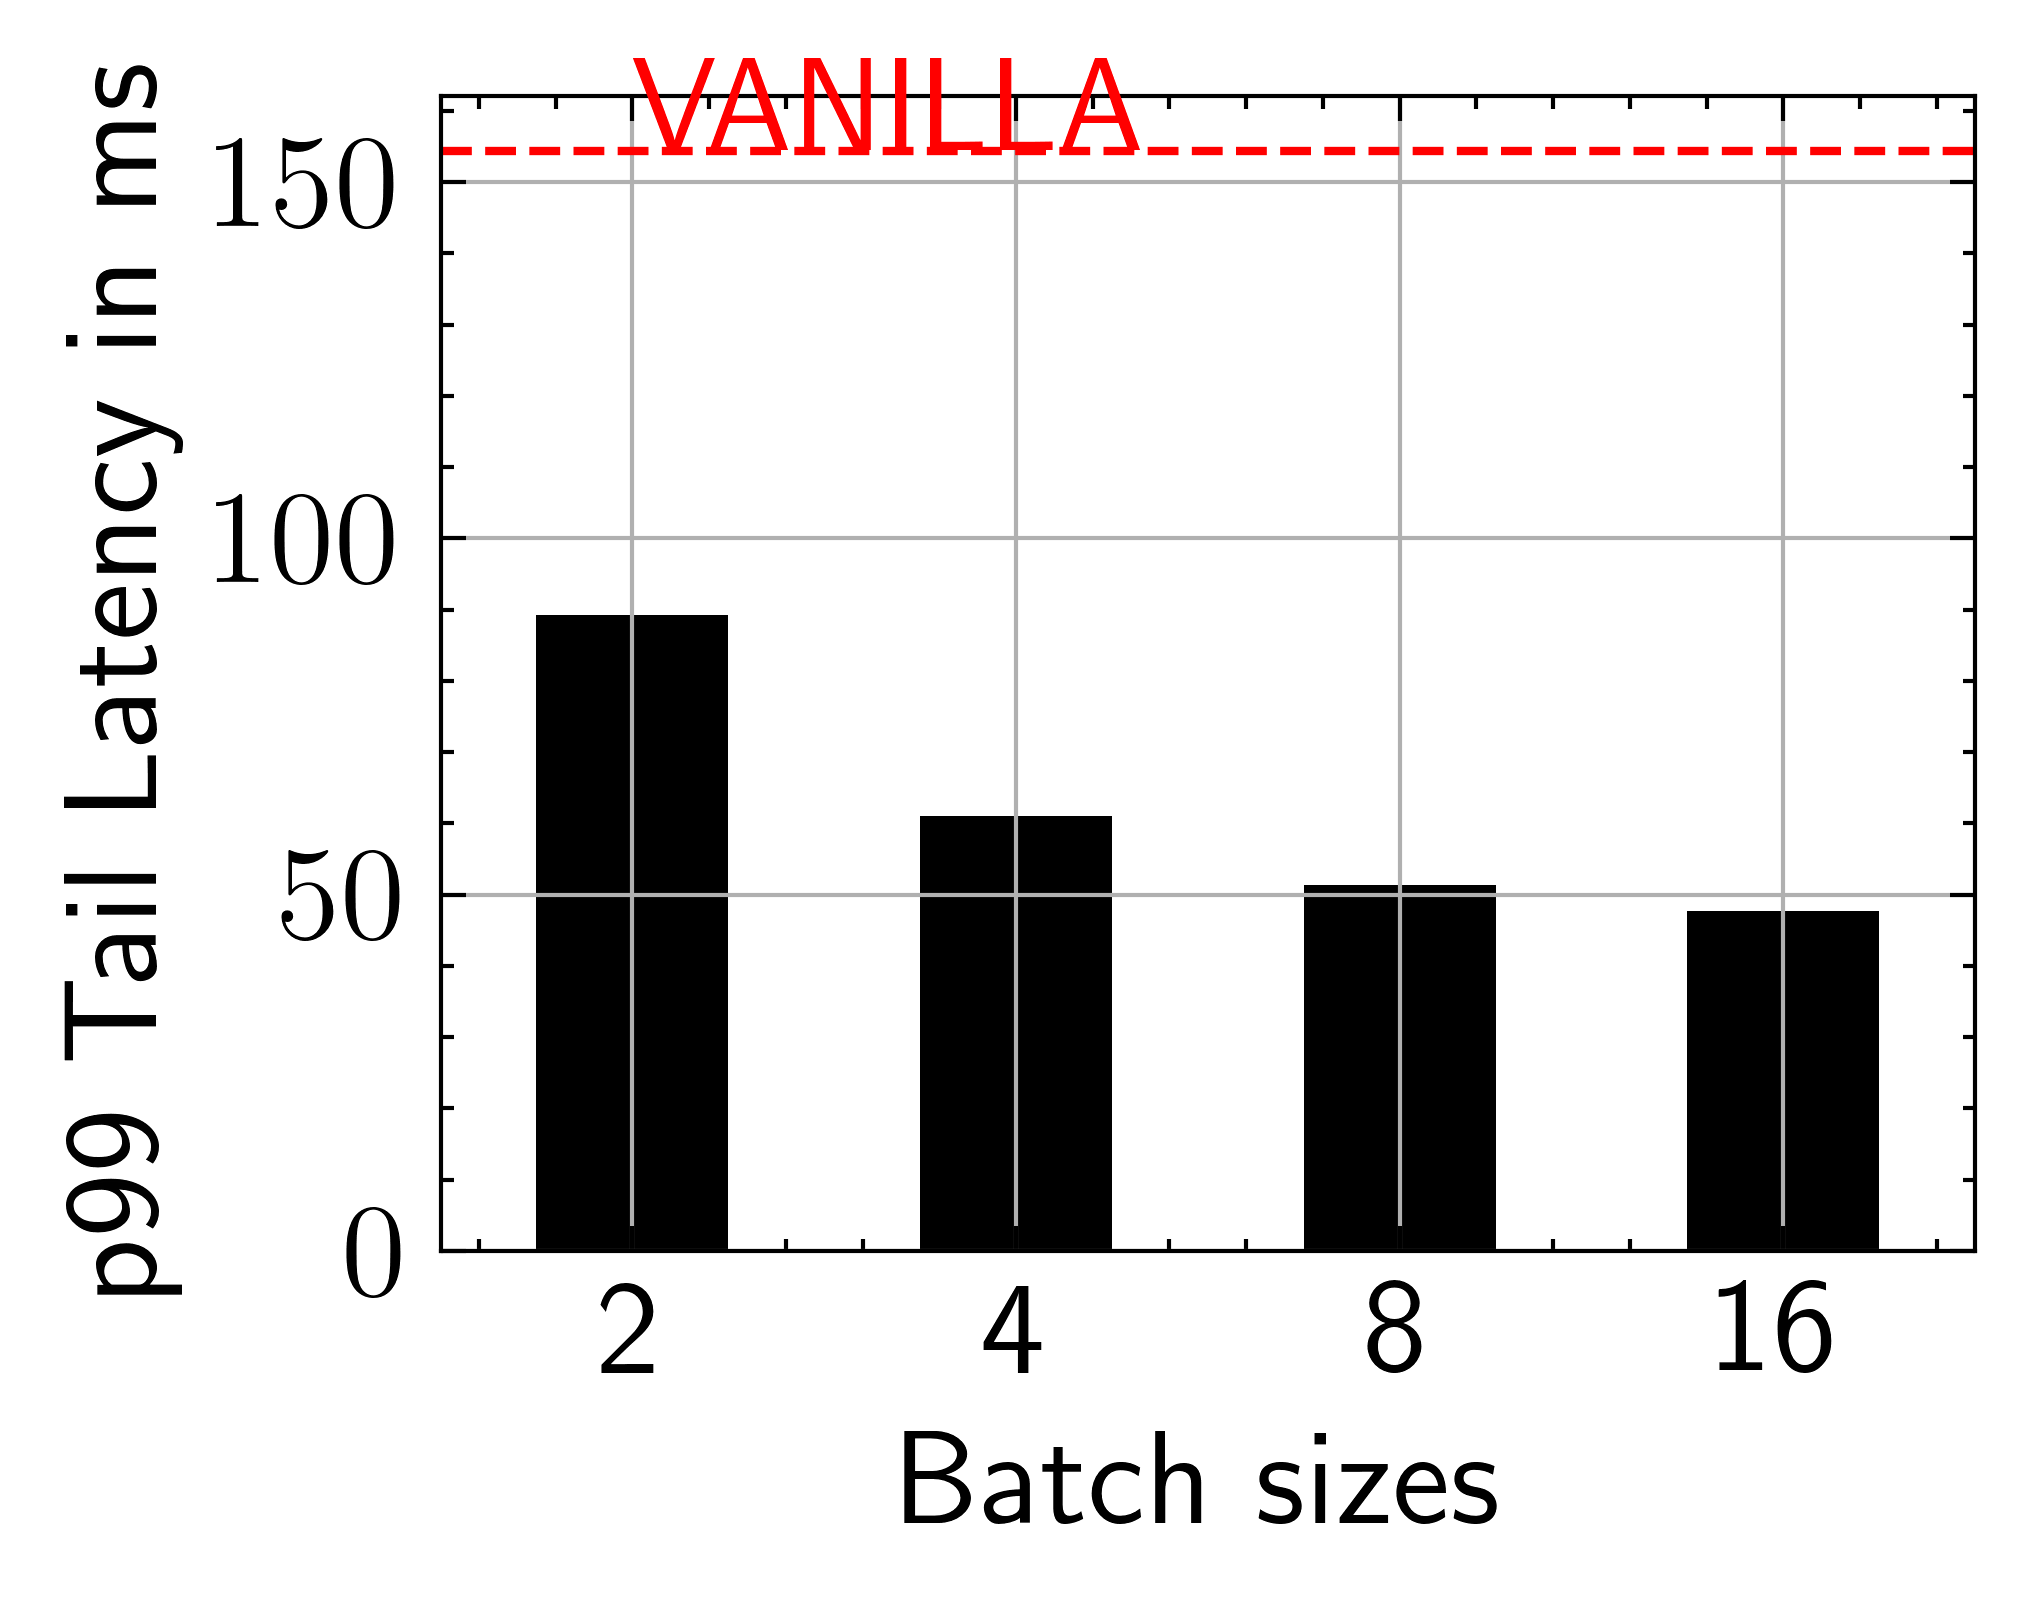

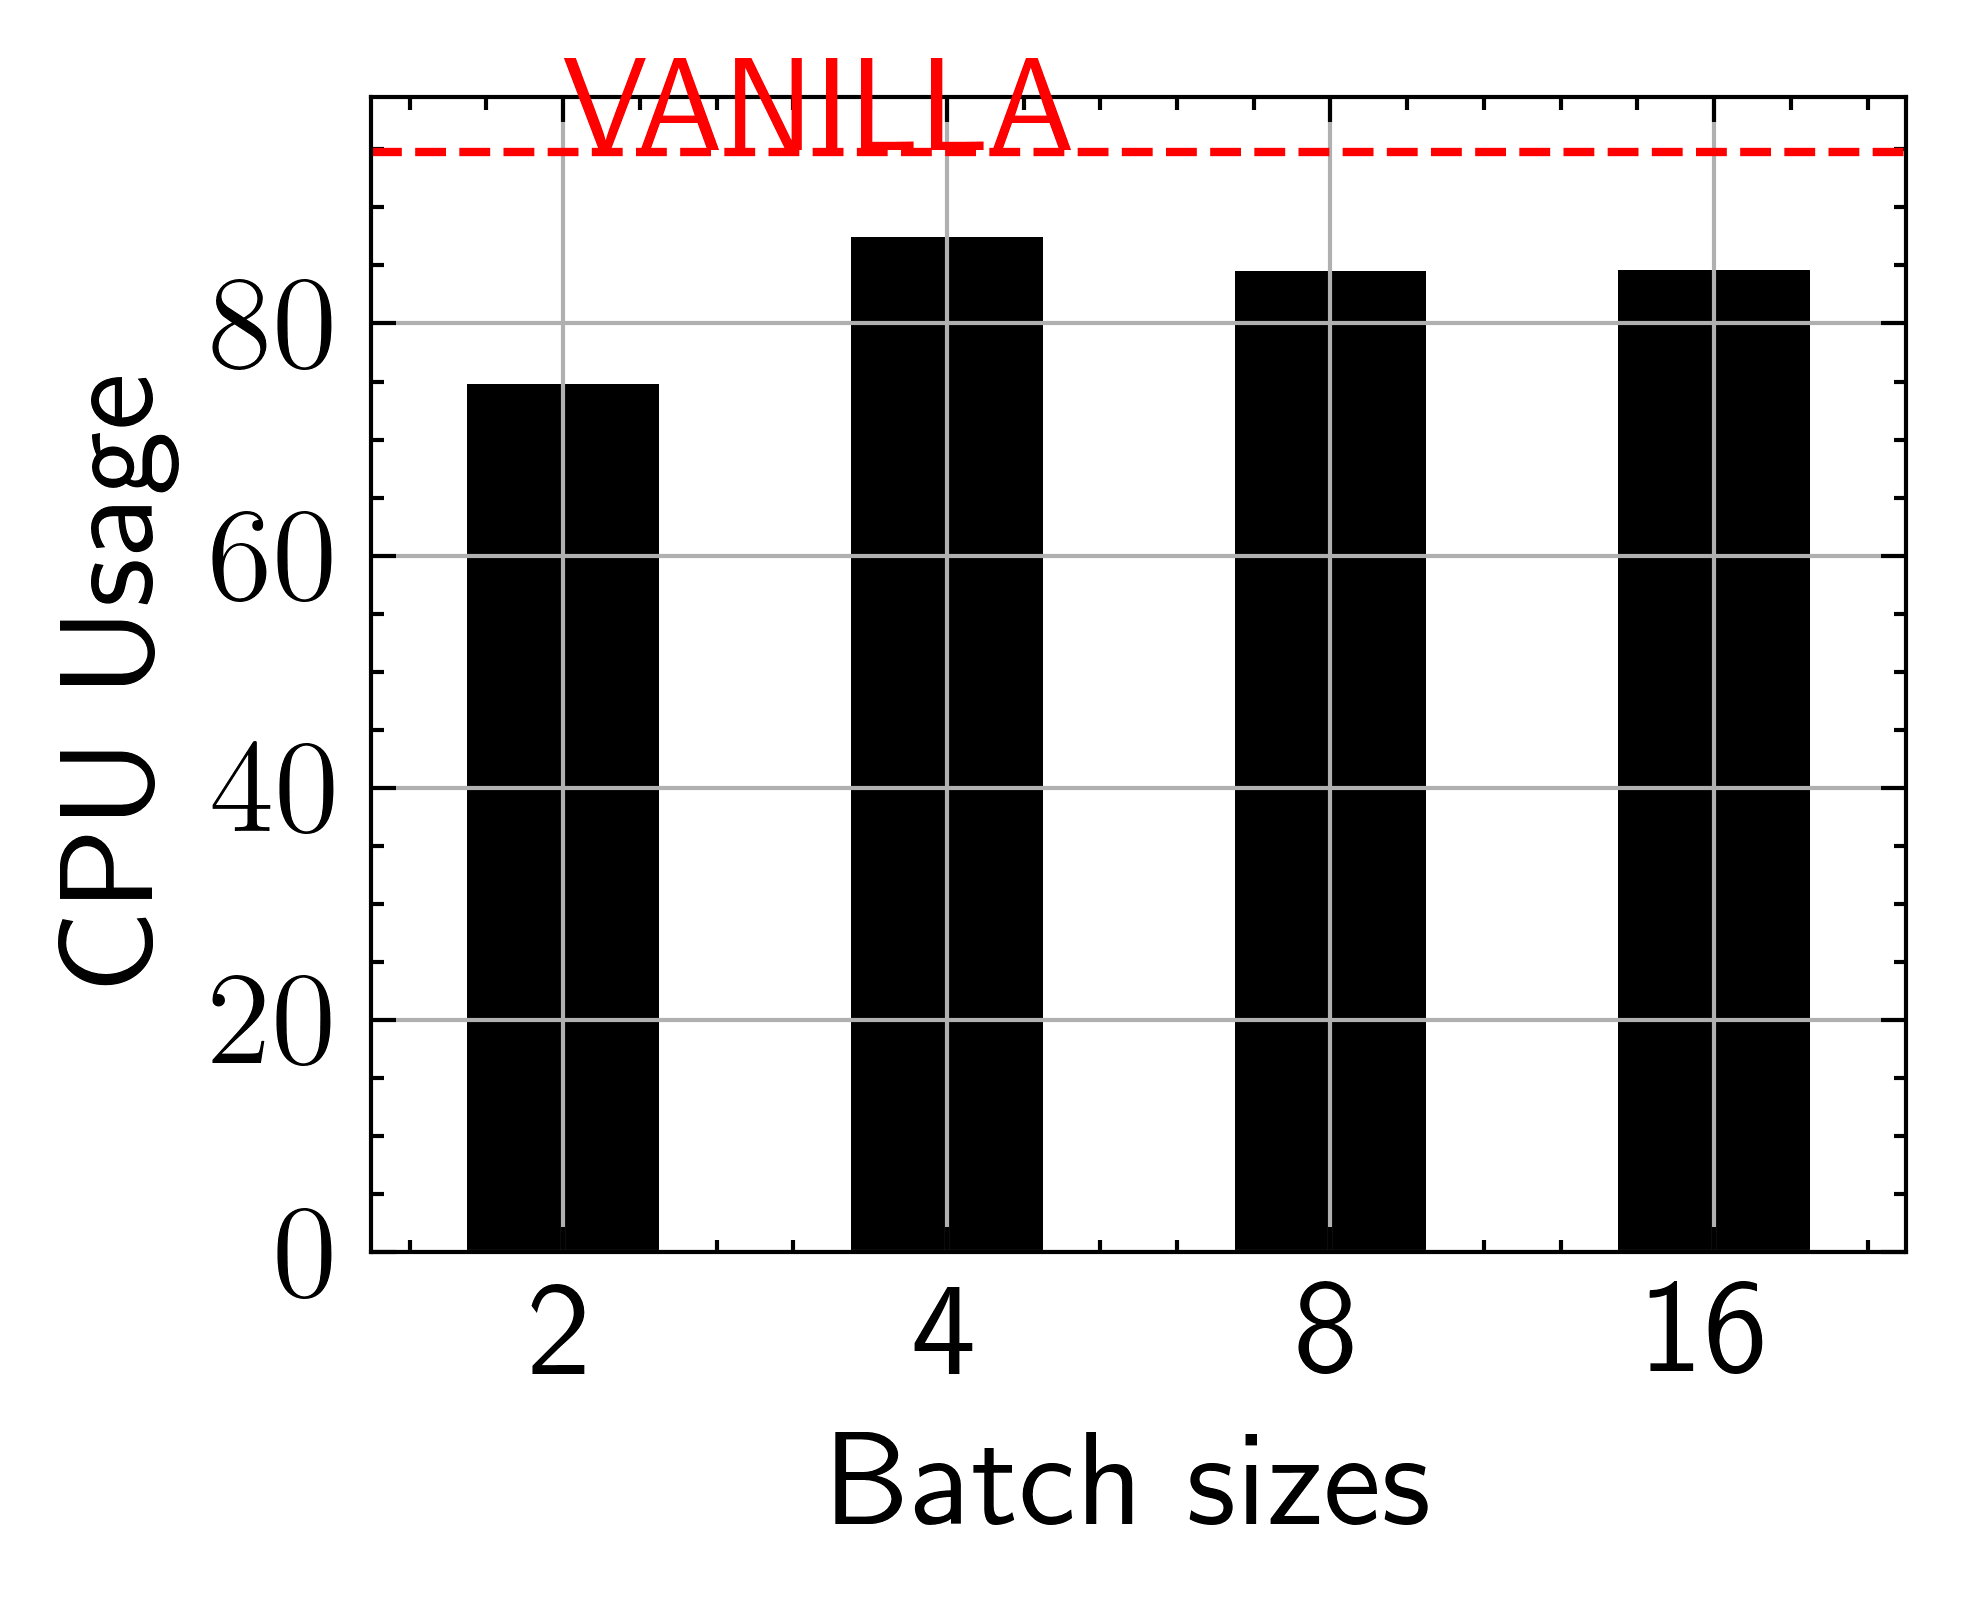

In [85]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'batch'
y = 'spinlock'
xlabel='Batch sizes'
ylabel='Spinlock CPU Usage'
ylim = [0, 10]


plot_(df_batch, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing,
     savefig='ssrb-bc-spinlock.pdf'
)

plot_(df_batch, x, 'throughput', xlabel, "Throughput in Gbps",
     ylim=[0, 25],
     normal_value=df_vanilla.iloc[0].throughput,
     text_spacing=text_spacing,
     savefig='ssrb-bc-tp.pdf'
)

plot_(df_batch, x, 'latency', xlabel, "p99 Tail Latency in ms",
     ylim=None,
     normal_value=df_vanilla.iloc[0].latency,
     text_spacing=text_spacing,
     savefig='ssrb-bc-lat.pdf'
)

plot_(df_batch, x, 'cpu', xlabel, "CPU Usage",
     ylim=None,
     normal_value=df_vanilla.iloc[0].cpu,
     text_spacing=text_spacing,
     savefig='ssrb-bc-cpu.pdf'
)

In [86]:
df_mrb

,throughput,latency,cpu,num_pids,decrypt_worker,decrypt_packet,spinlock,cache_miss,cache_ops,context_switch,...,end,ring,duration,cache_miss_ratio,l1_ratio,llc_ratio,migrations/s,cs/s,faults/s,variant
0,17.851828,51.185236,77.473684,291,74.59,123.49,1.20,30573,44618,86598,...,17766.879557,2,5.007419,0.685217,0.999576,0.814501,1726.837718,17293.939253,10.384591,MRB
0,13.565329,60.517174,54.736842,264,69.46,103.16,1.26,29001,44303,87041,...,18076.524112,4,5.006575,0.654606,0.996262,0.749800,1459.480783,17385.338280,8.788443,MRB
0,9.970191,146.045000,36.710526,218,64.55,82.08,1.39,27765,43058,84942,...,18386.320624,8,5.006920,0.644828,0.990206,0.655818,781.718102,16964.920550,13.980651,MRB
0,6.169977,350.765000,21.075263,165,64.41,65.56,1.84,21190,40661,84444,...,18695.870397,18,5.006101,0.521138,0.993539,0.404039,295.239748,16868.217401,10.387325,MRB


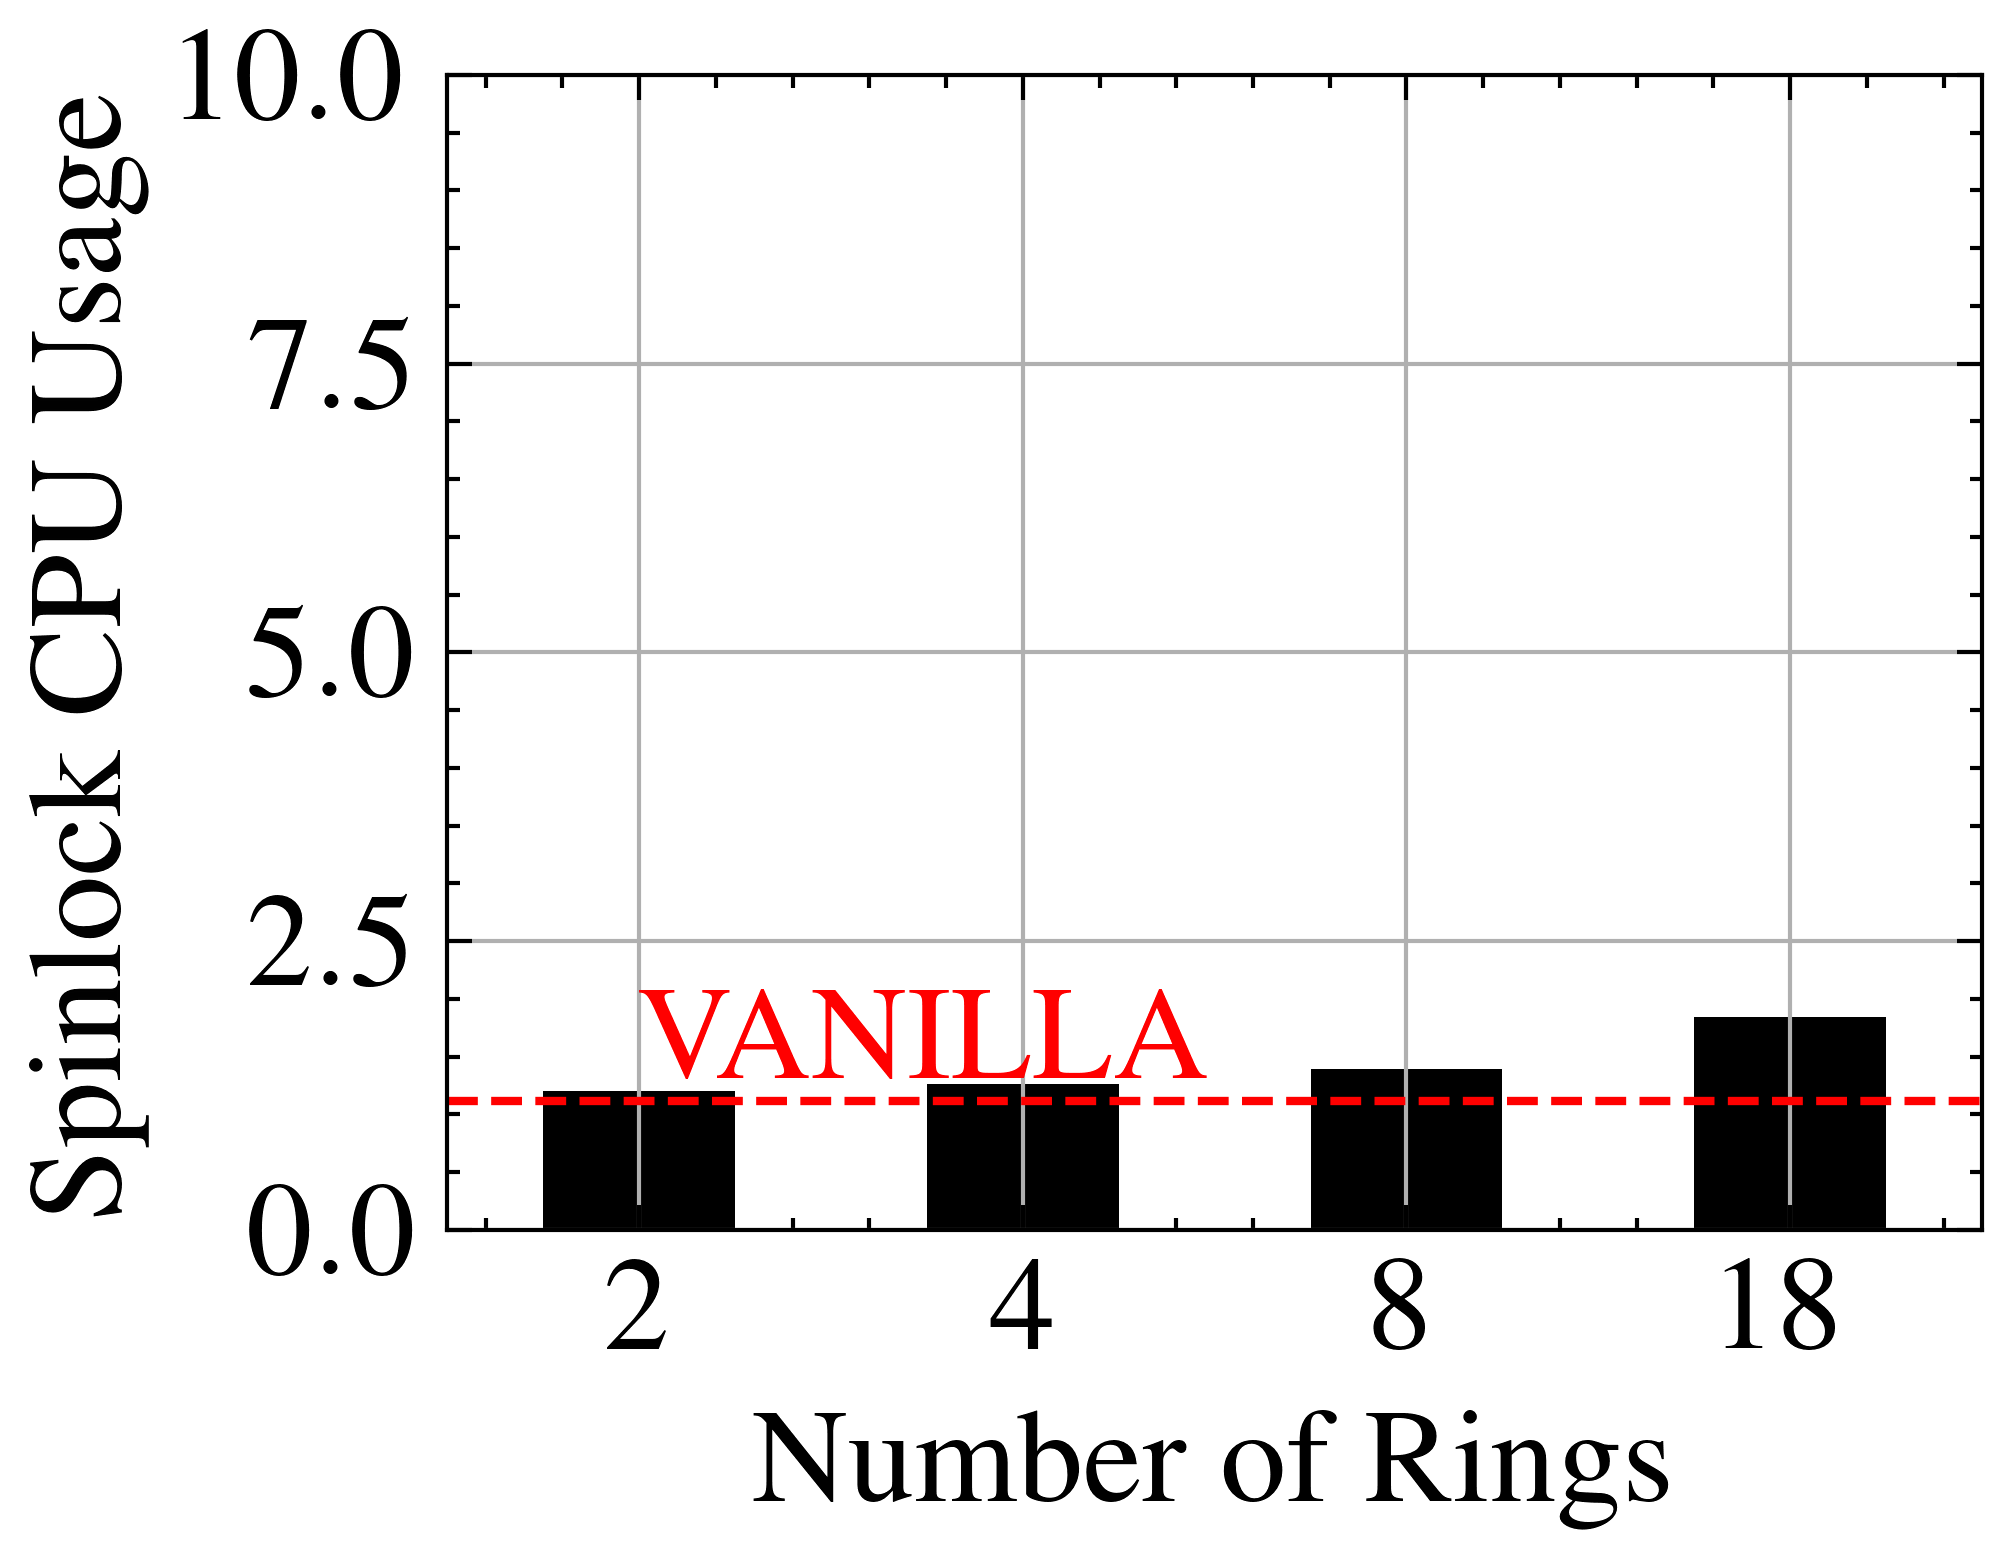

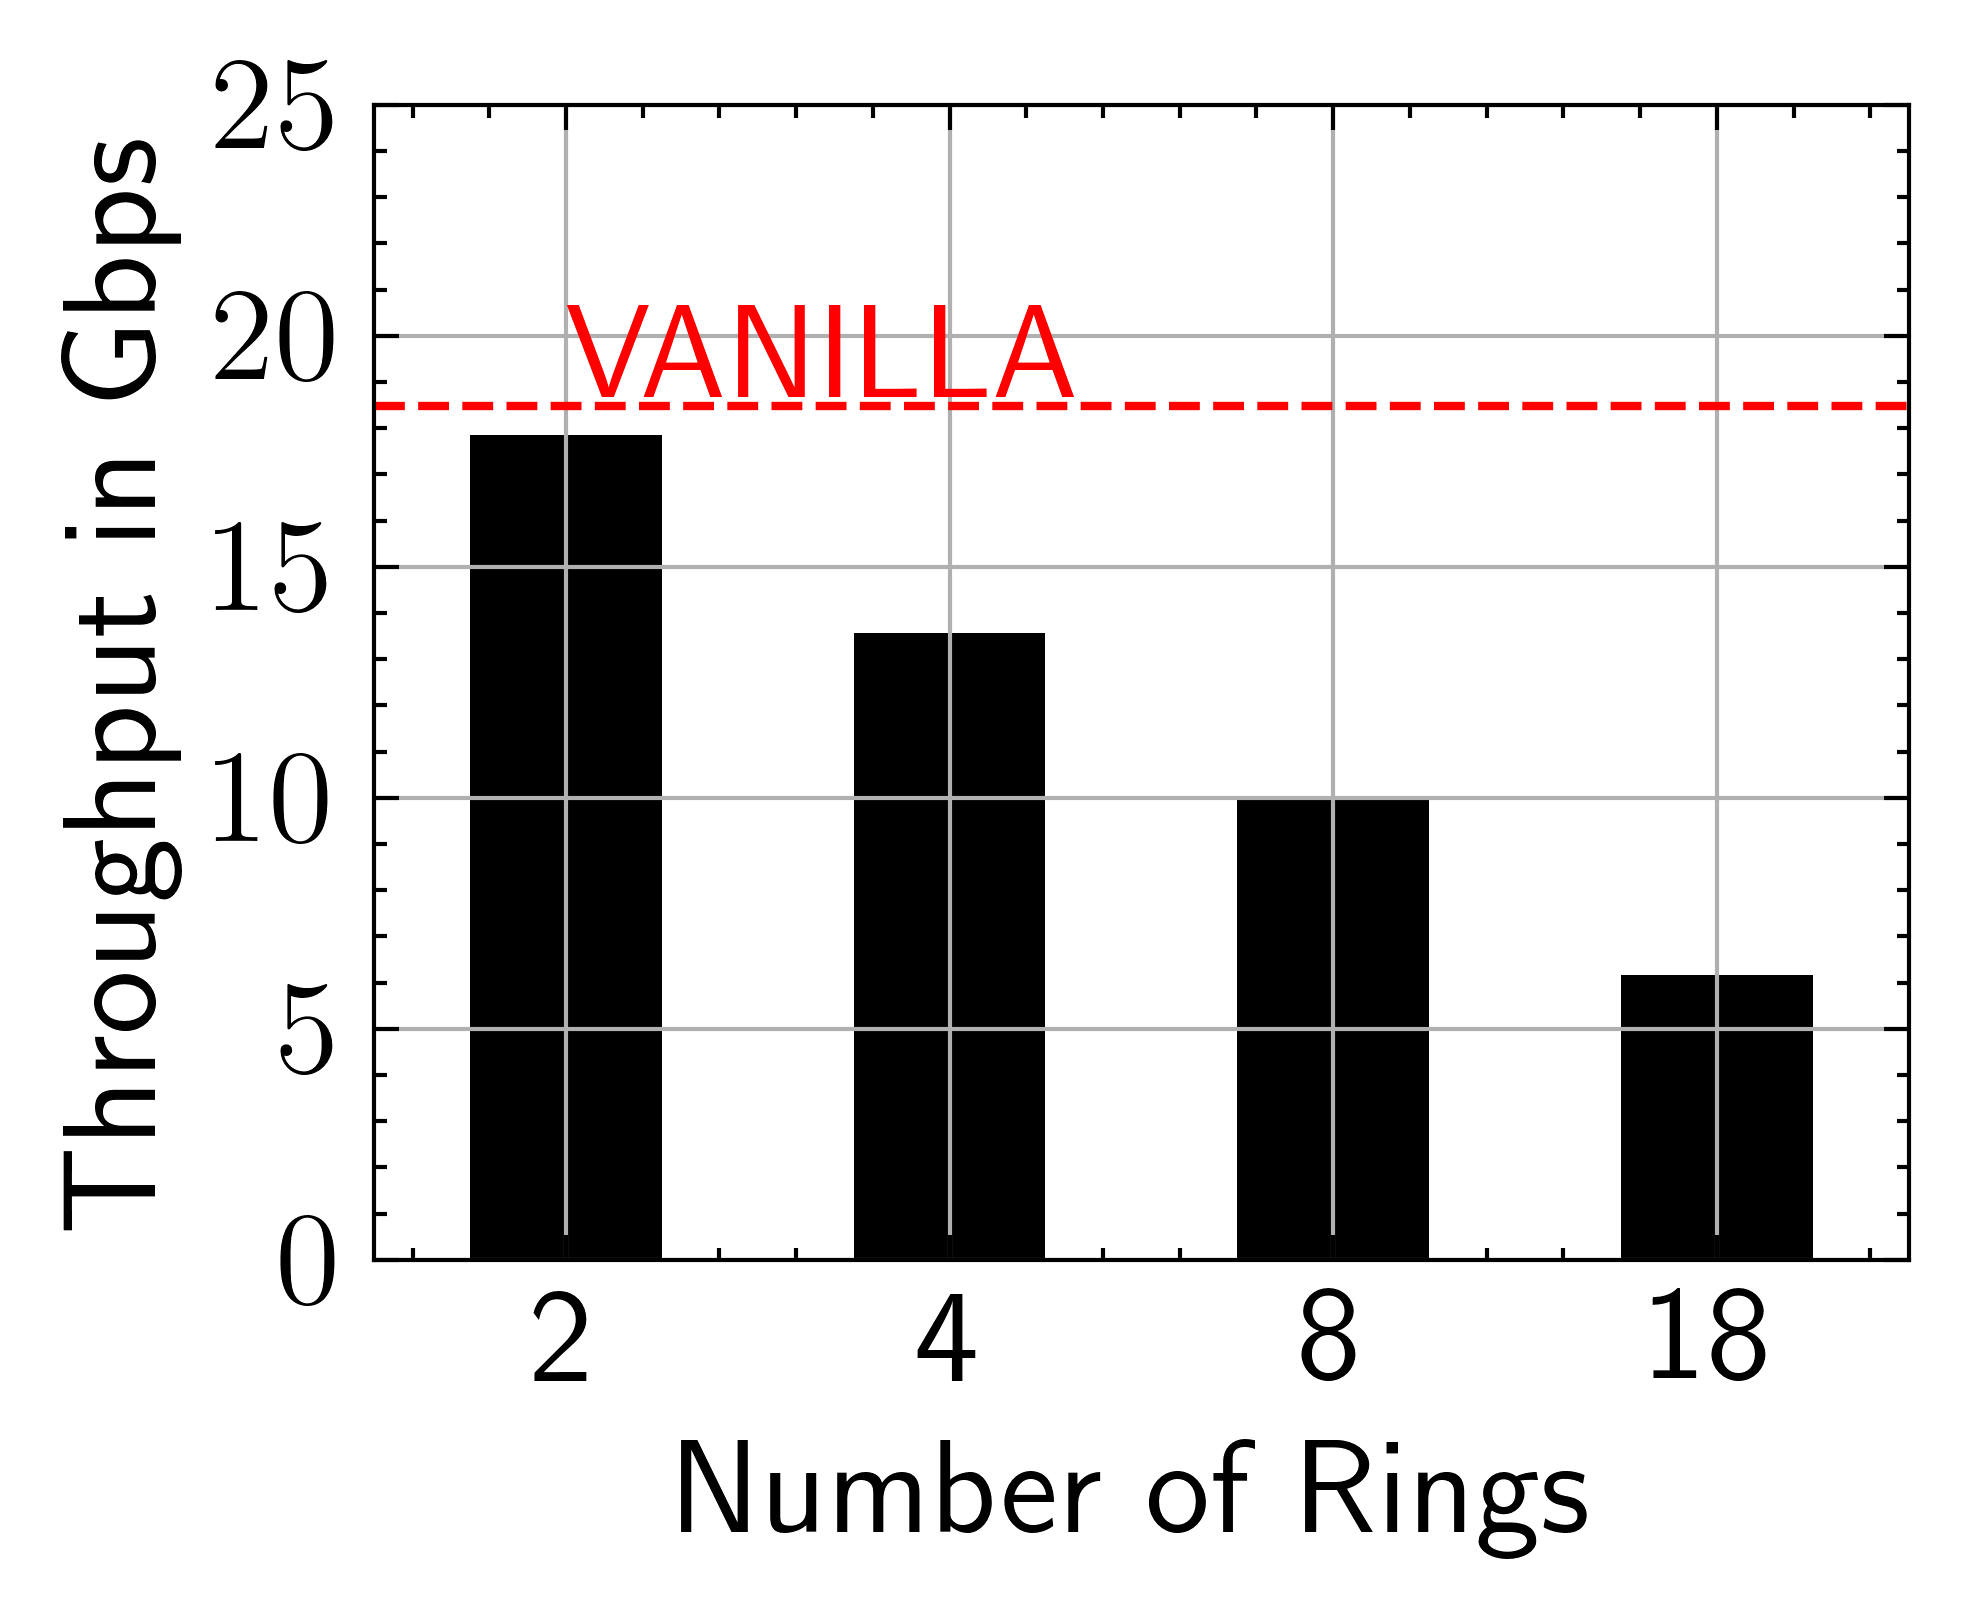

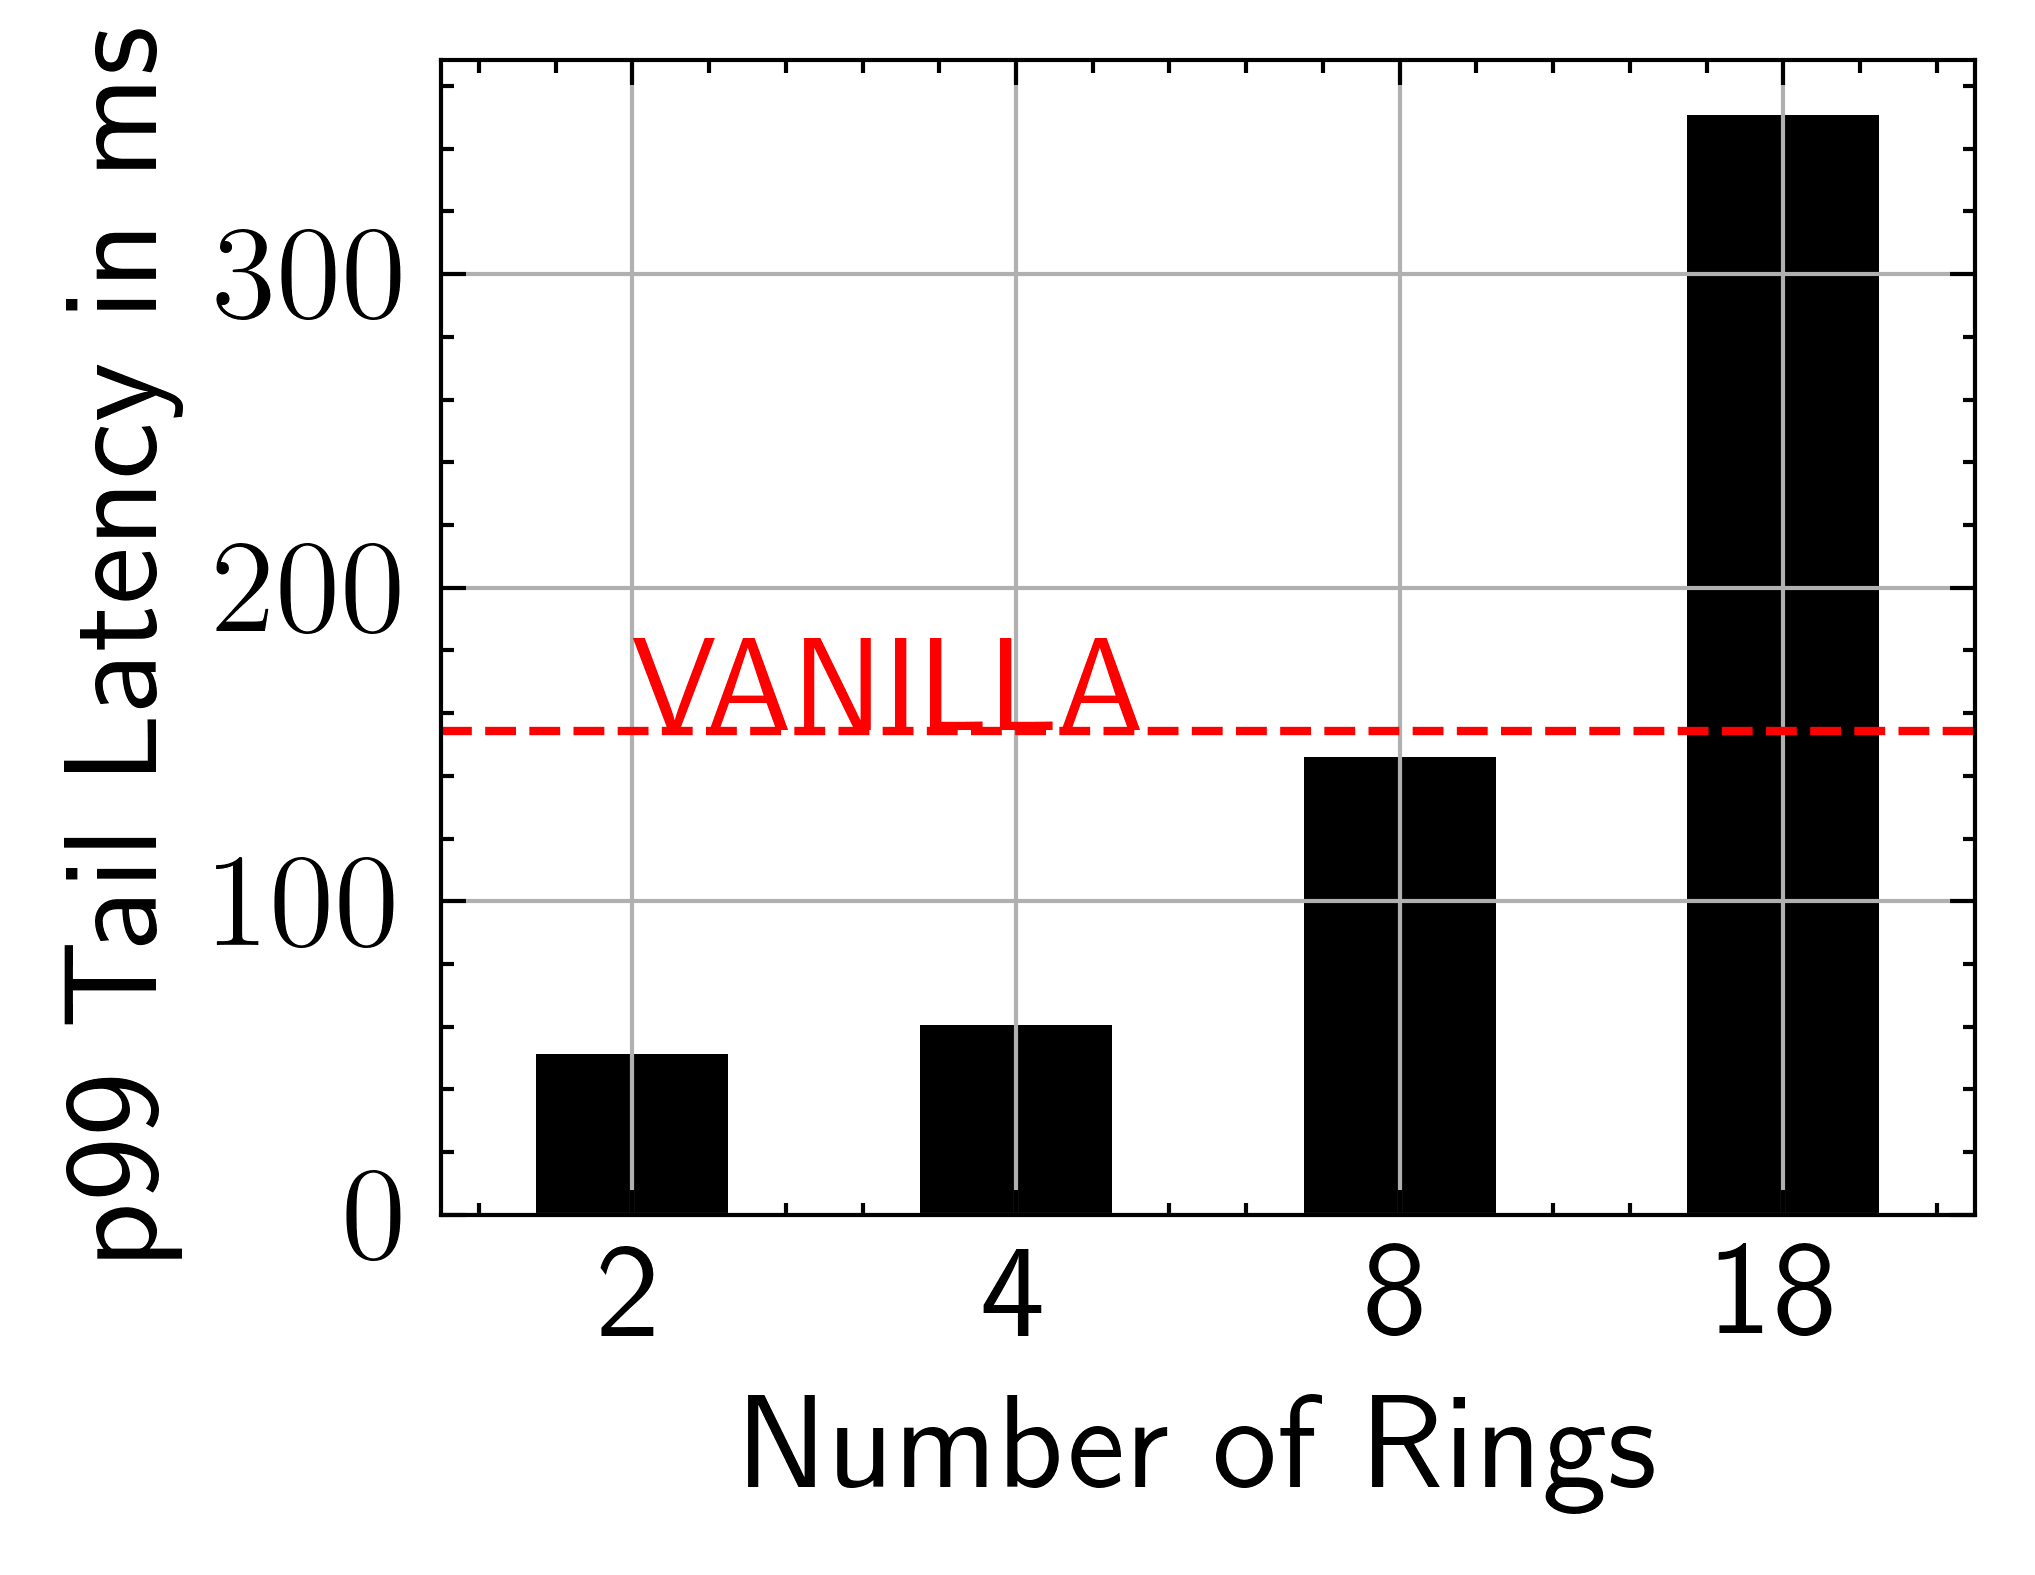

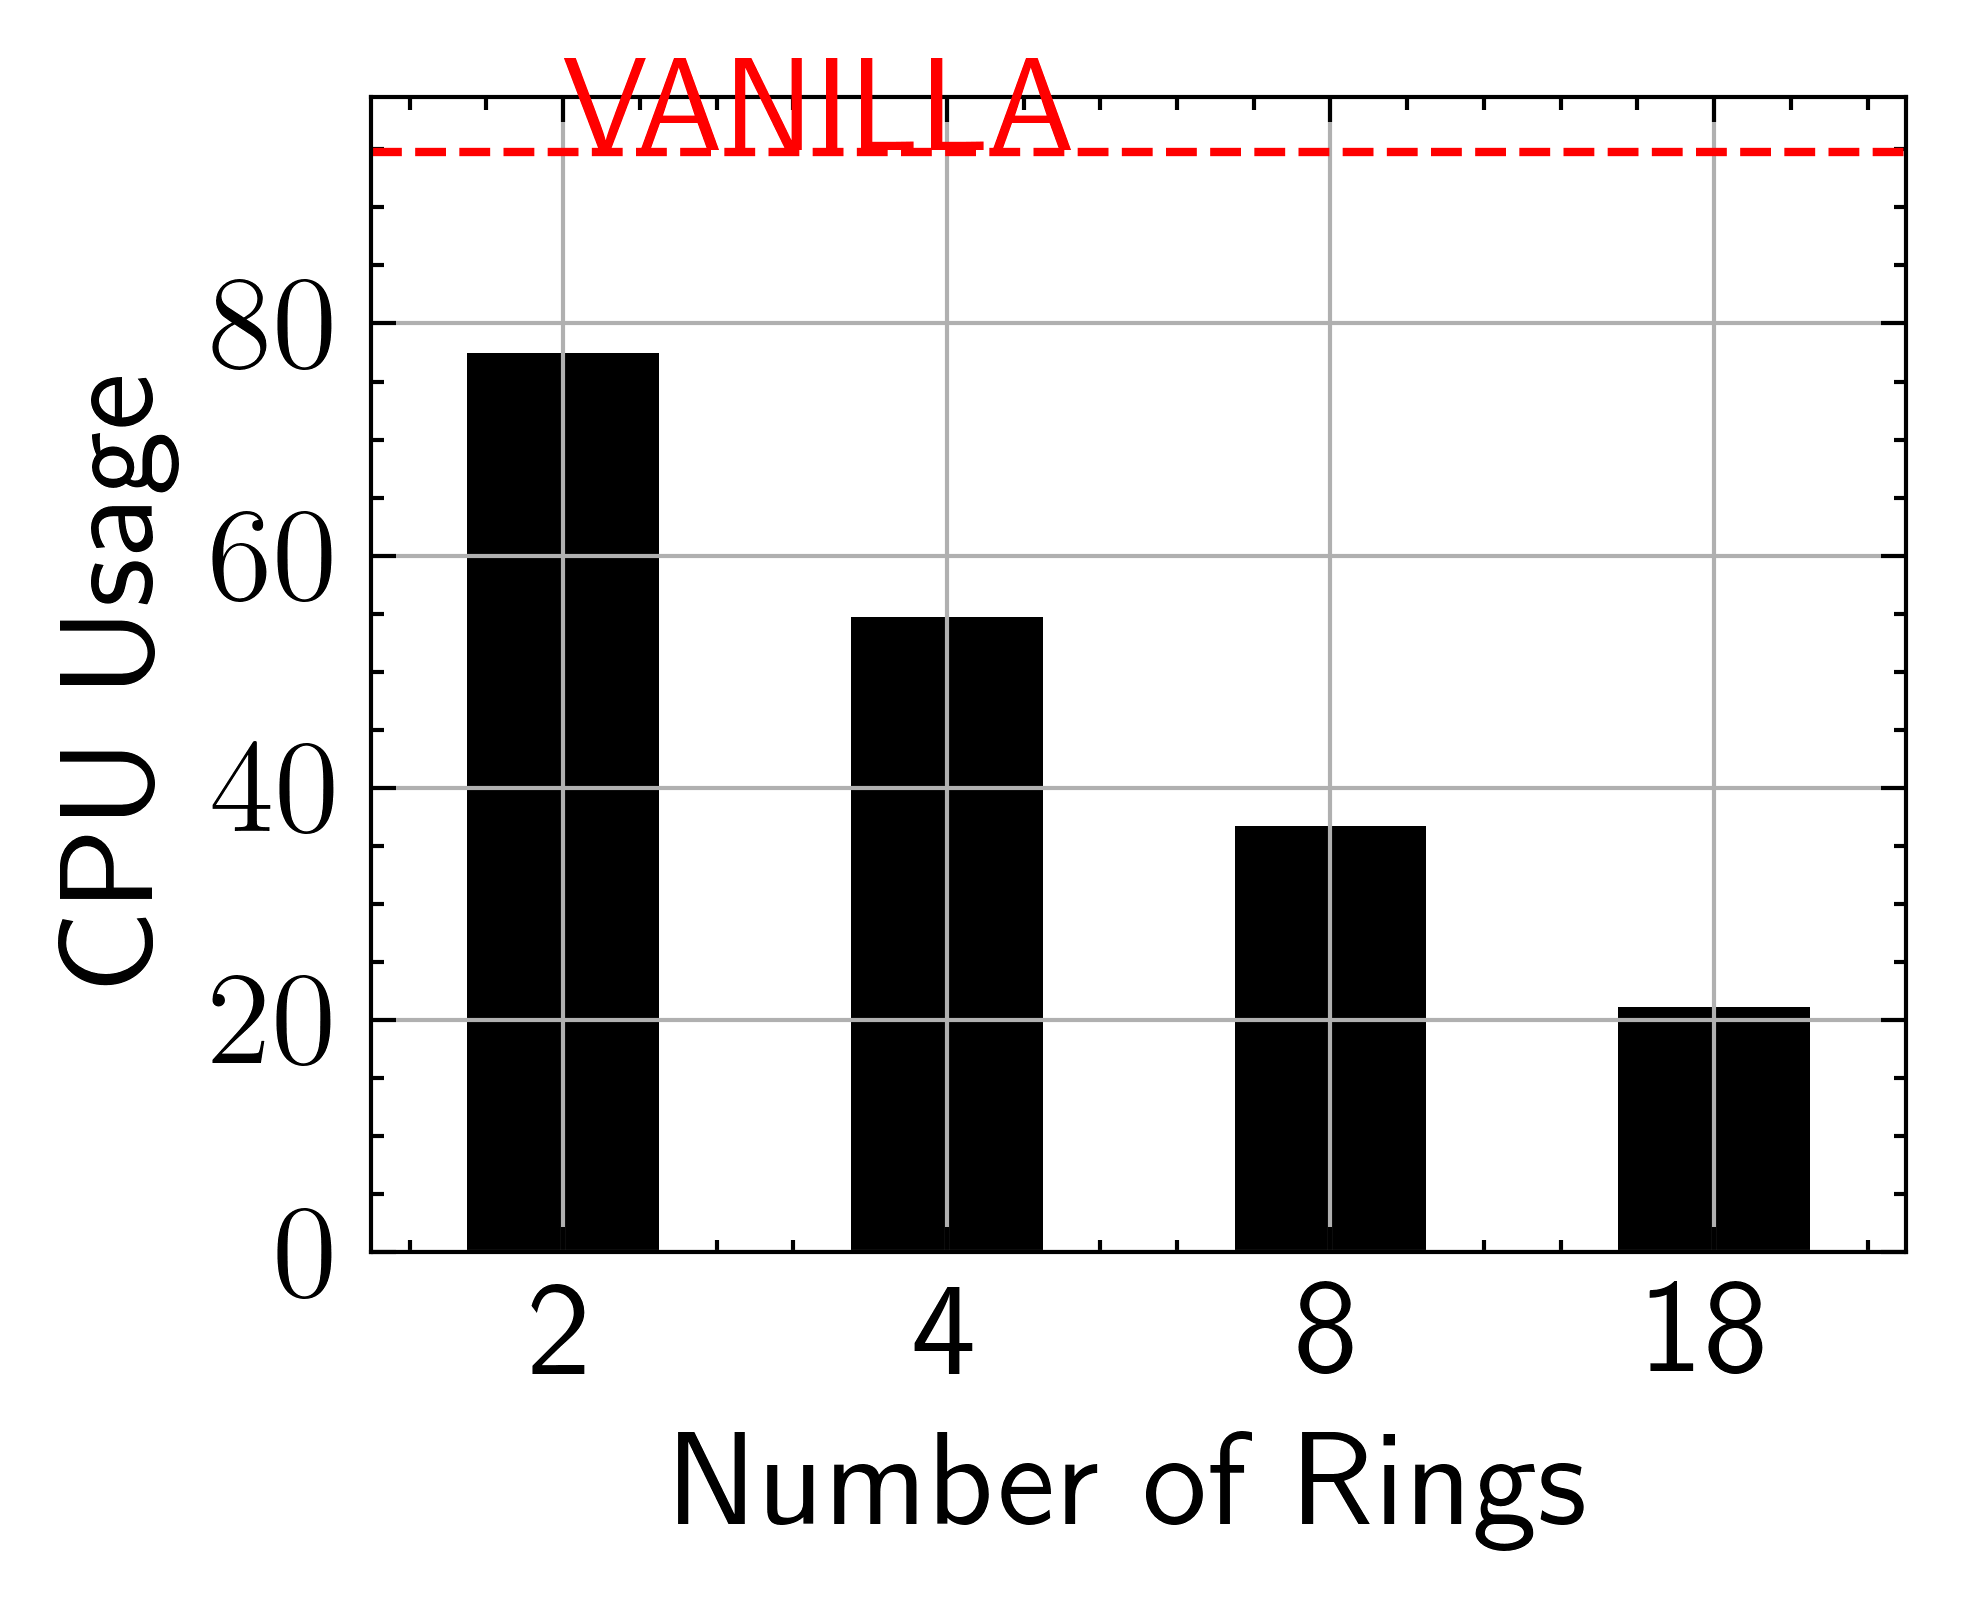

In [87]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'ring'
y = 'spinlock'
xlabel='Number of Rings'
ylabel='Spinlock CPU Usage'


plot_(df_mrb, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing
)

plot_(df_mrb, x, 'throughput', xlabel, "Throughput in Gbps",
     ylim=[0, 25],
     normal_value=df_vanilla.iloc[0].throughput,
     text_spacing=text_spacing,
     savefig='mrb-tp.pdf'
)

plot_(df_mrb, x, 'latency', xlabel, "p99 Tail Latency in ms",
     ylim=None,
     normal_value=df_vanilla.iloc[0].latency,
     text_spacing=text_spacing,
     savefig='mrb-lat.pdf'
)

plot_(df_mrb, x, 'cpu', xlabel, "CPU Usage",
     ylim=None,
     normal_value=df_vanilla.iloc[0].cpu,
     text_spacing=text_spacing,
     savefig='mrb-cpu.pdf'
)

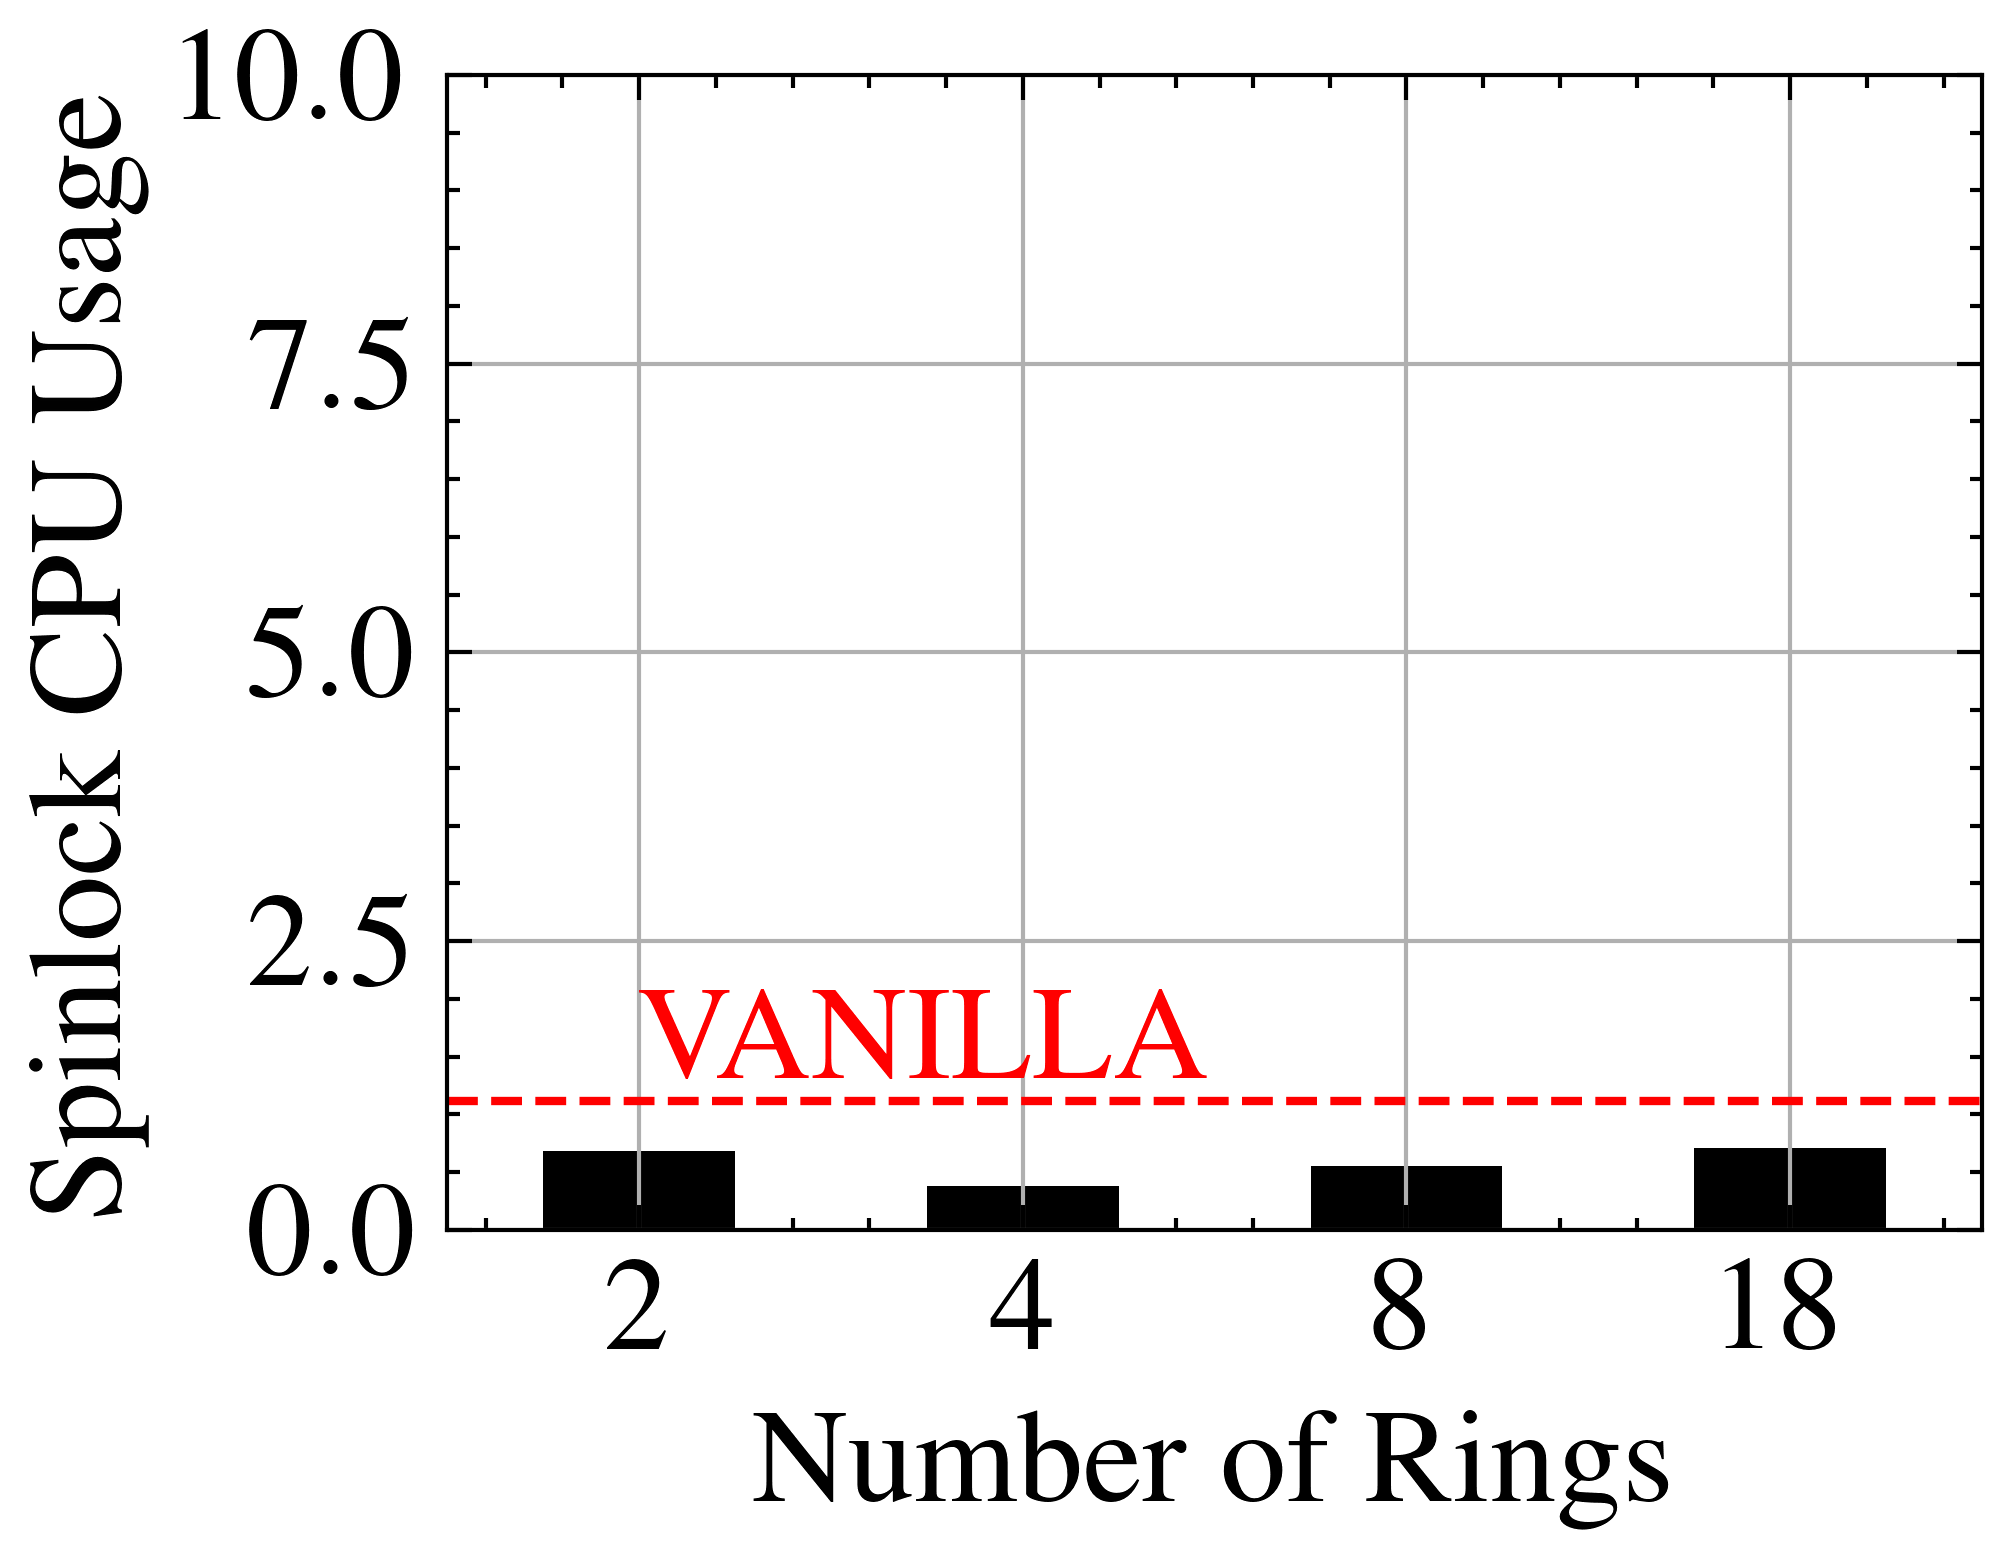

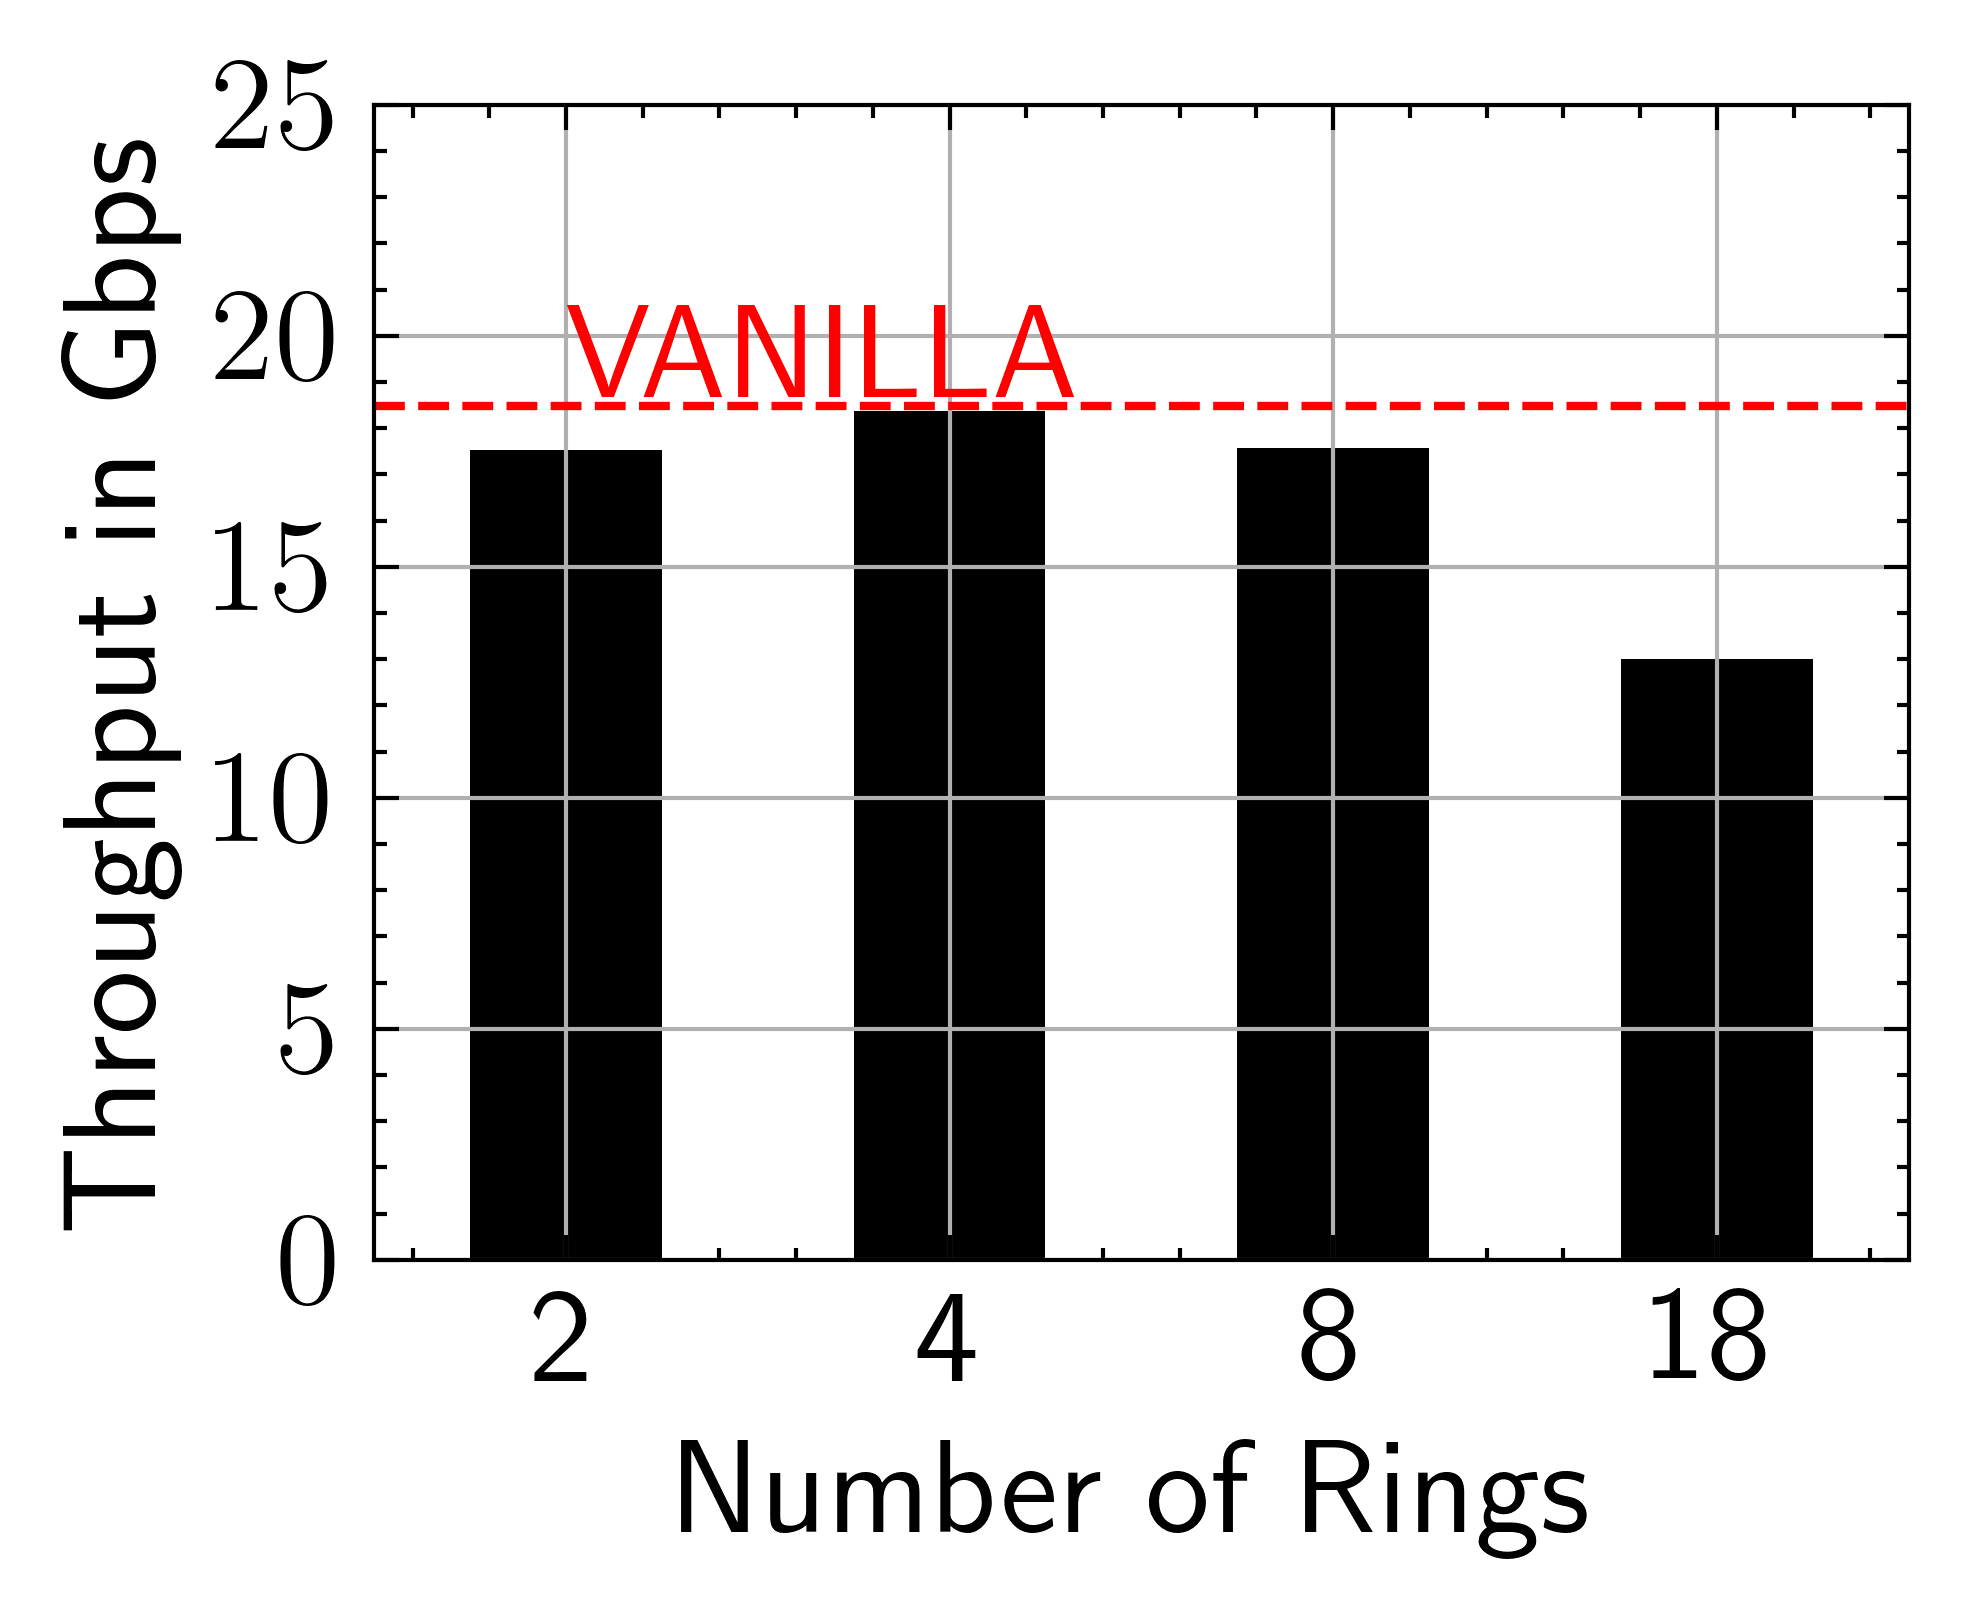

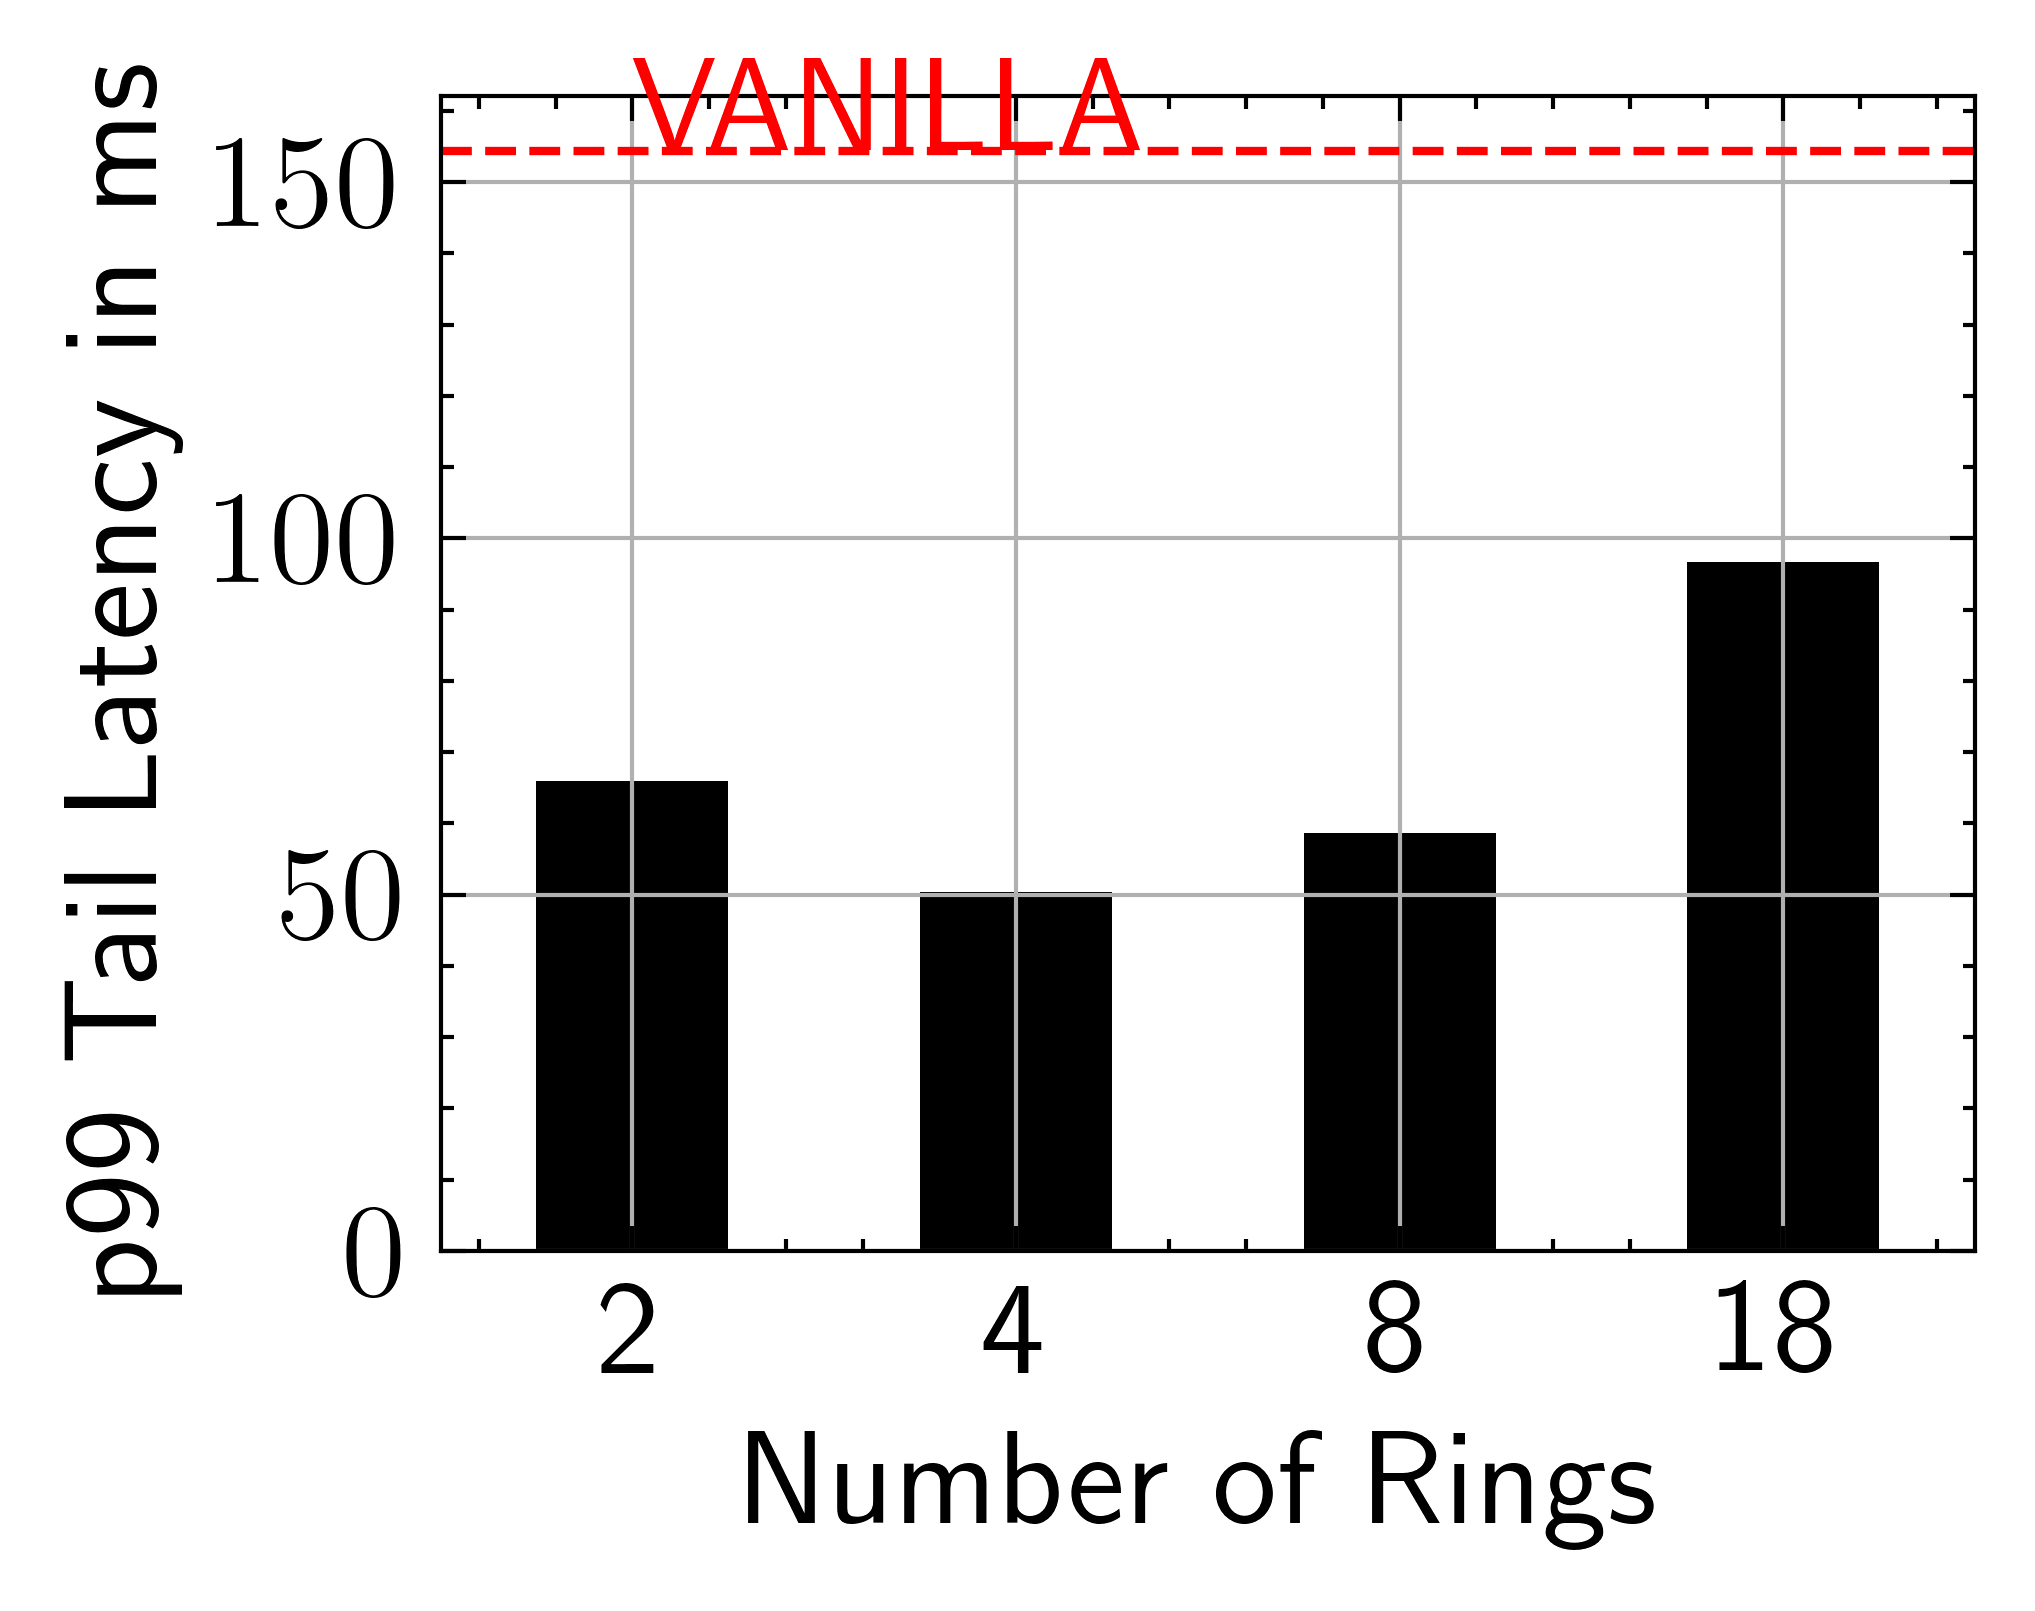

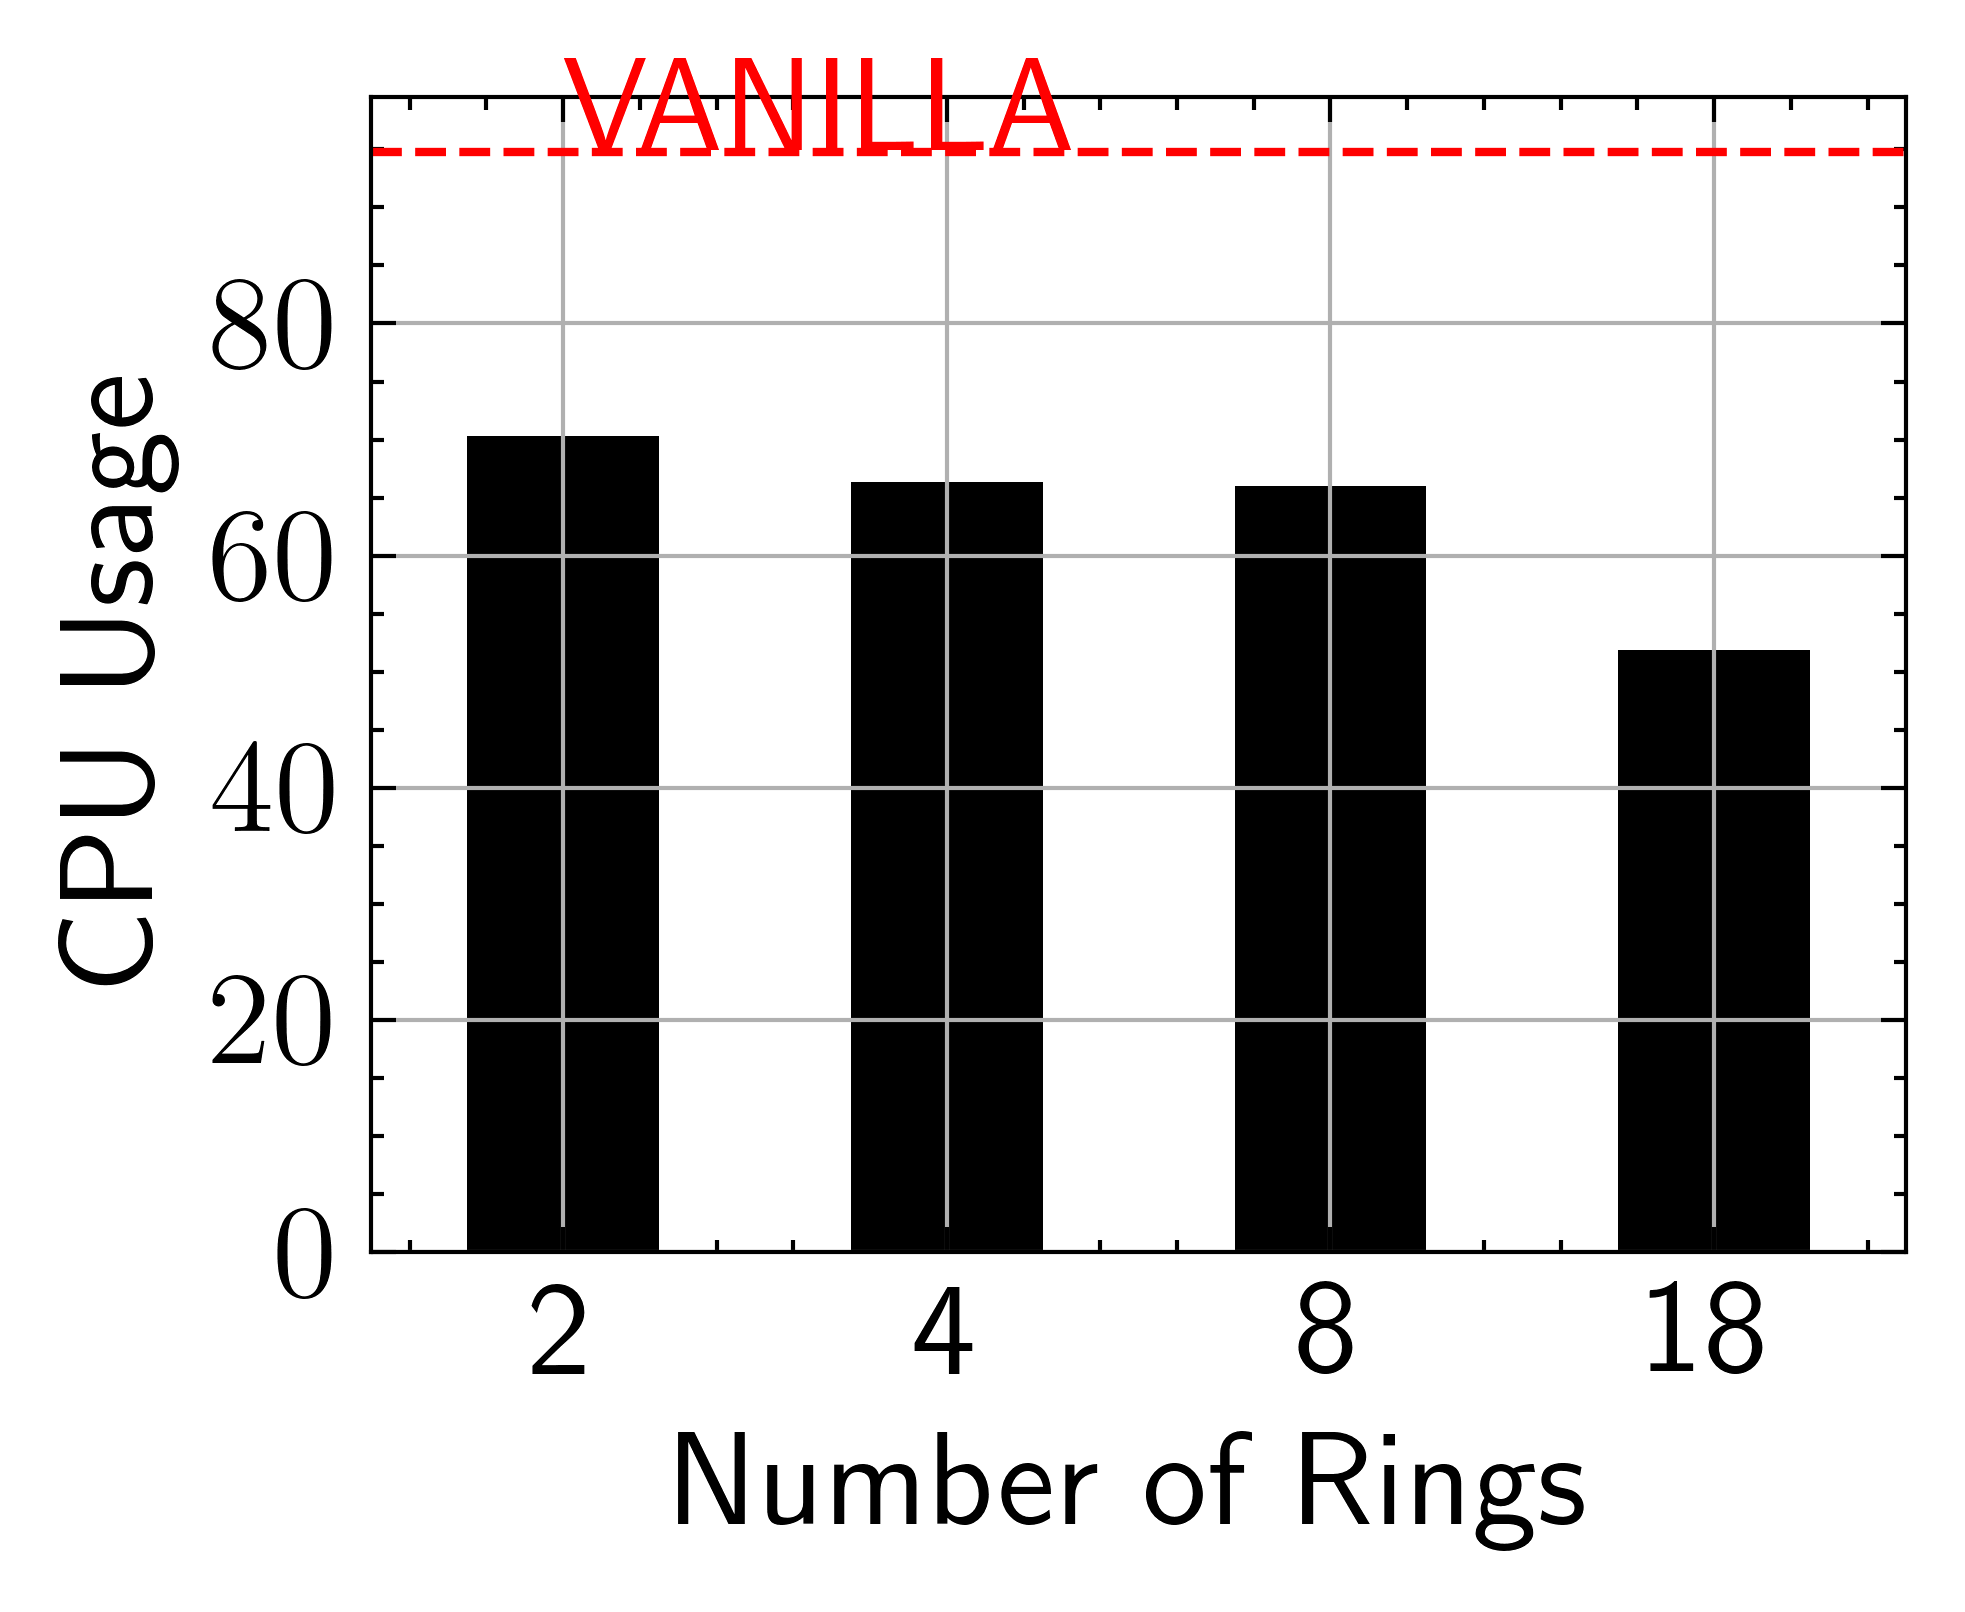

In [88]:
normal_value = df_vanilla.iloc[0].spinlock
text_offset = 0
text_spacing = .2
x = 'ring'
y = 'spinlock'
xlabel='Number of Rings'
ylabel='Spinlock CPU Usage'


plot_(df_mrb_str, x, y, xlabel, ylabel,
     ylim=ylim,
     normal_value=normal_value,
     text_spacing=text_spacing
)

plot_(df_mrb_str, x, 'throughput', xlabel, "Throughput in Gbps",
     ylim=[0, 25],
     normal_value=df_vanilla.iloc[0].throughput,
     text_spacing=text_spacing,
     savefig='mrb-str-tp.pdf'
)

plot_(df_mrb_str, x, 'latency', xlabel, "p99 Tail Latency in ms",
     ylim=None,
     normal_value=df_vanilla.iloc[0].latency,
     text_spacing=text_spacing,
     savefig='mrb-str-lat.pdf'
)

plot_(df_mrb_str, x, 'cpu', xlabel, "CPU Usage",
     ylim=None,
     normal_value=df_vanilla.iloc[0].cpu,
     text_spacing=text_spacing,
     savefig='mrb-str-cpu.pdf'
)

In [95]:
best_batch = df_batch[df_batch.batch == 16]
best_mrb = df_mrb_str[df_mrb_str.ring == 4]

df = pd.concat([df_vanilla, df_nq, best_batch, best_mrb])

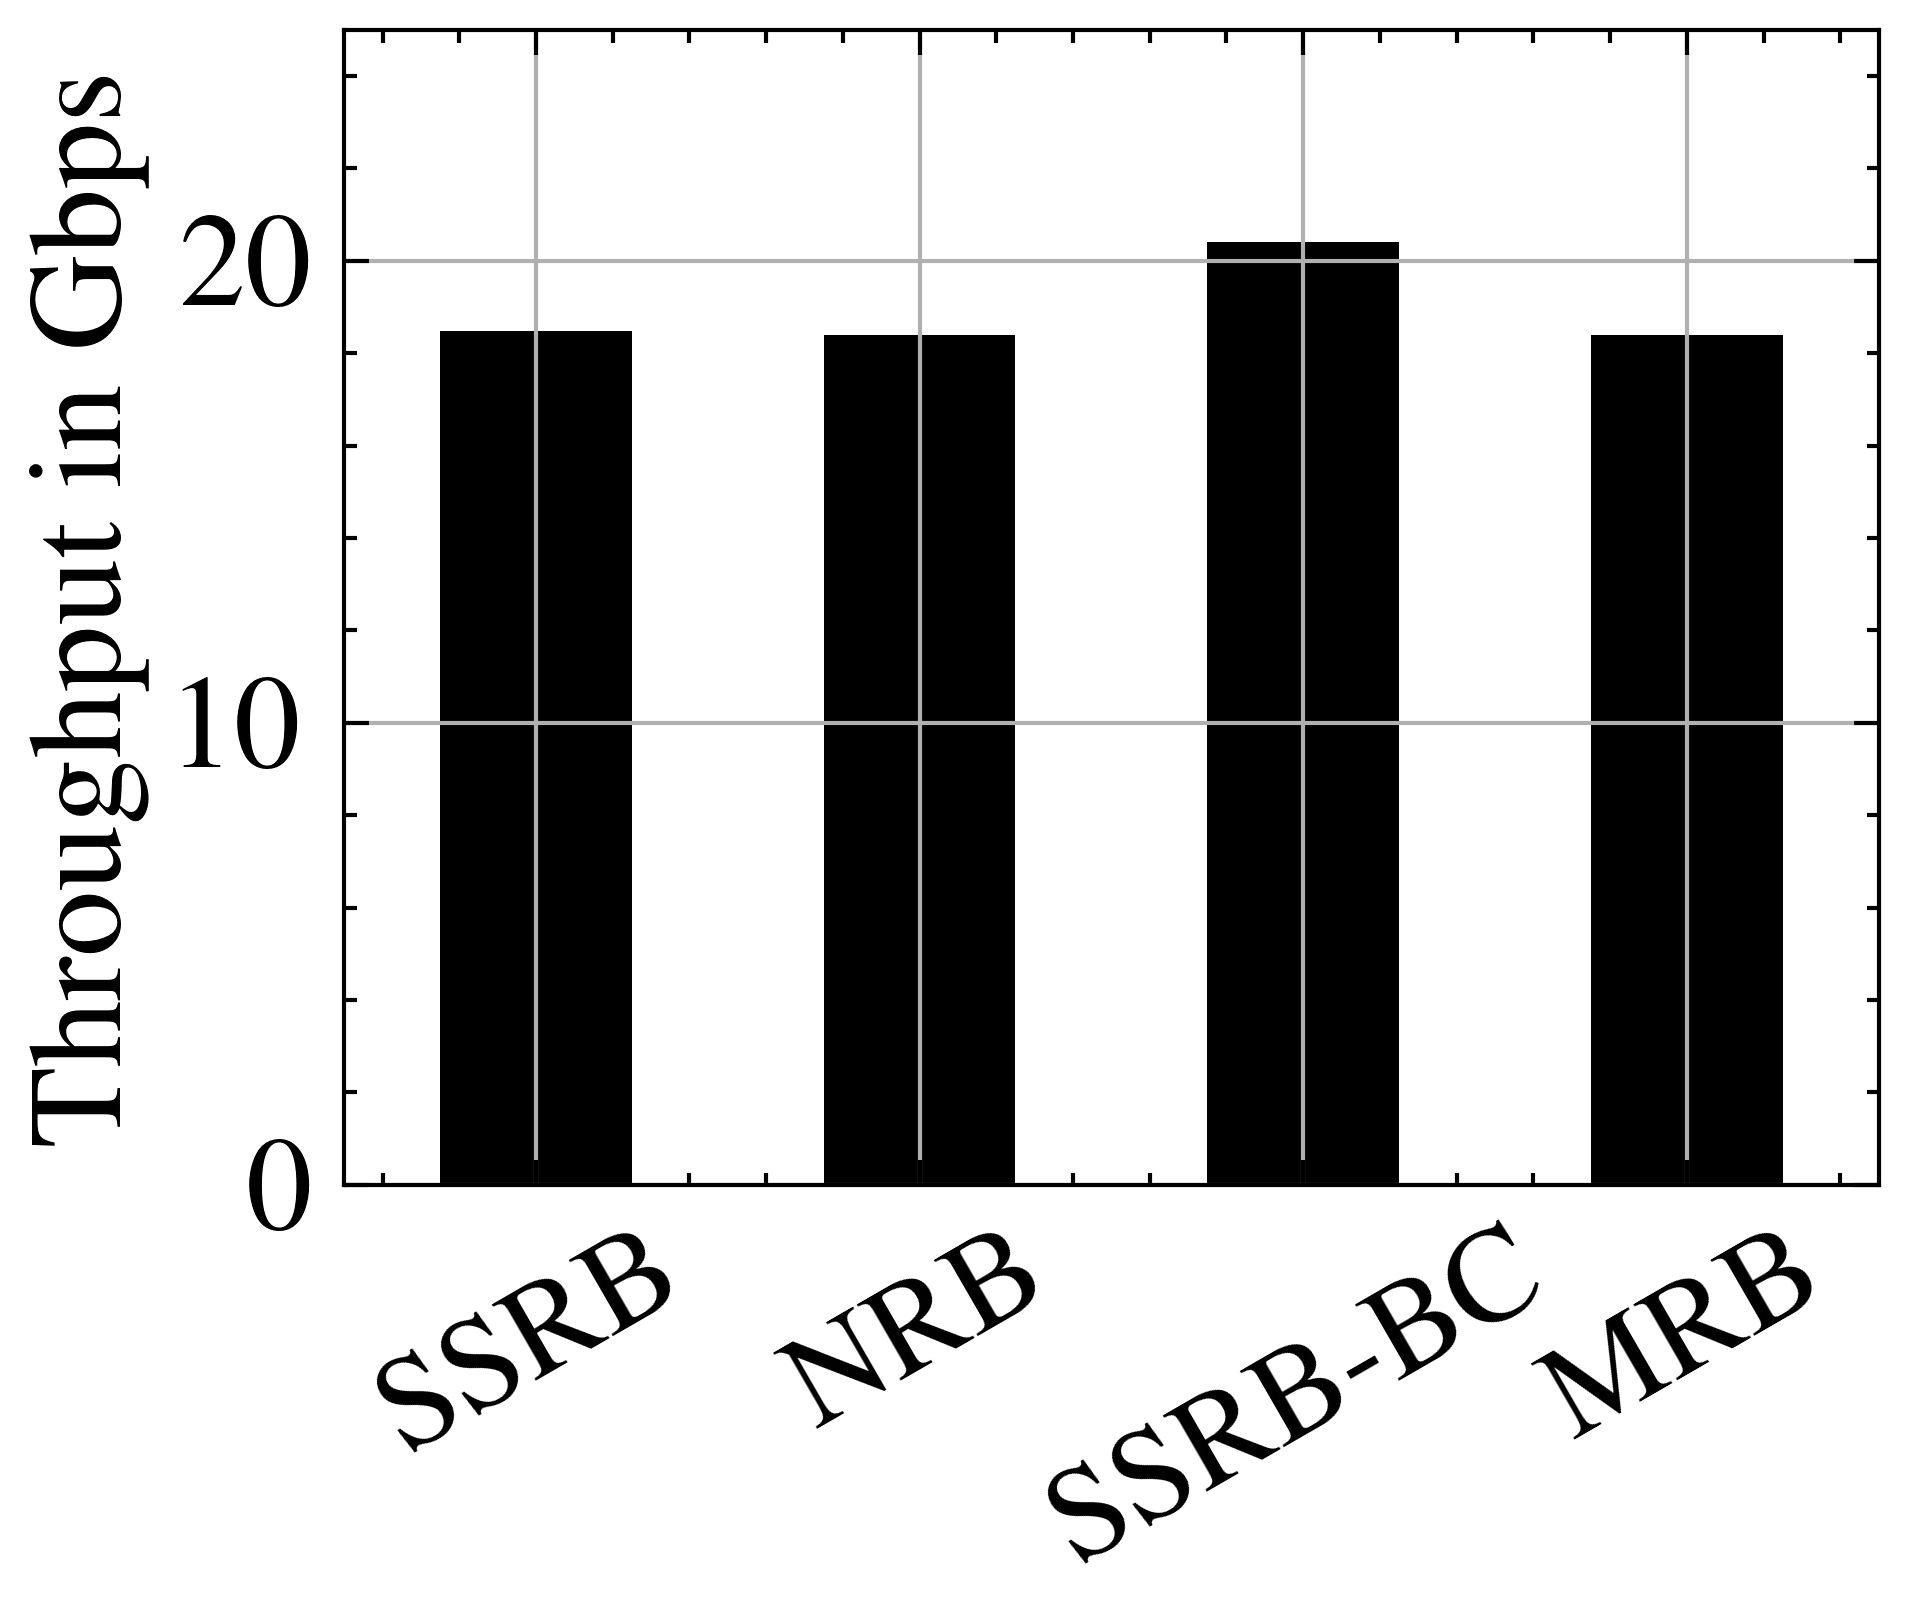

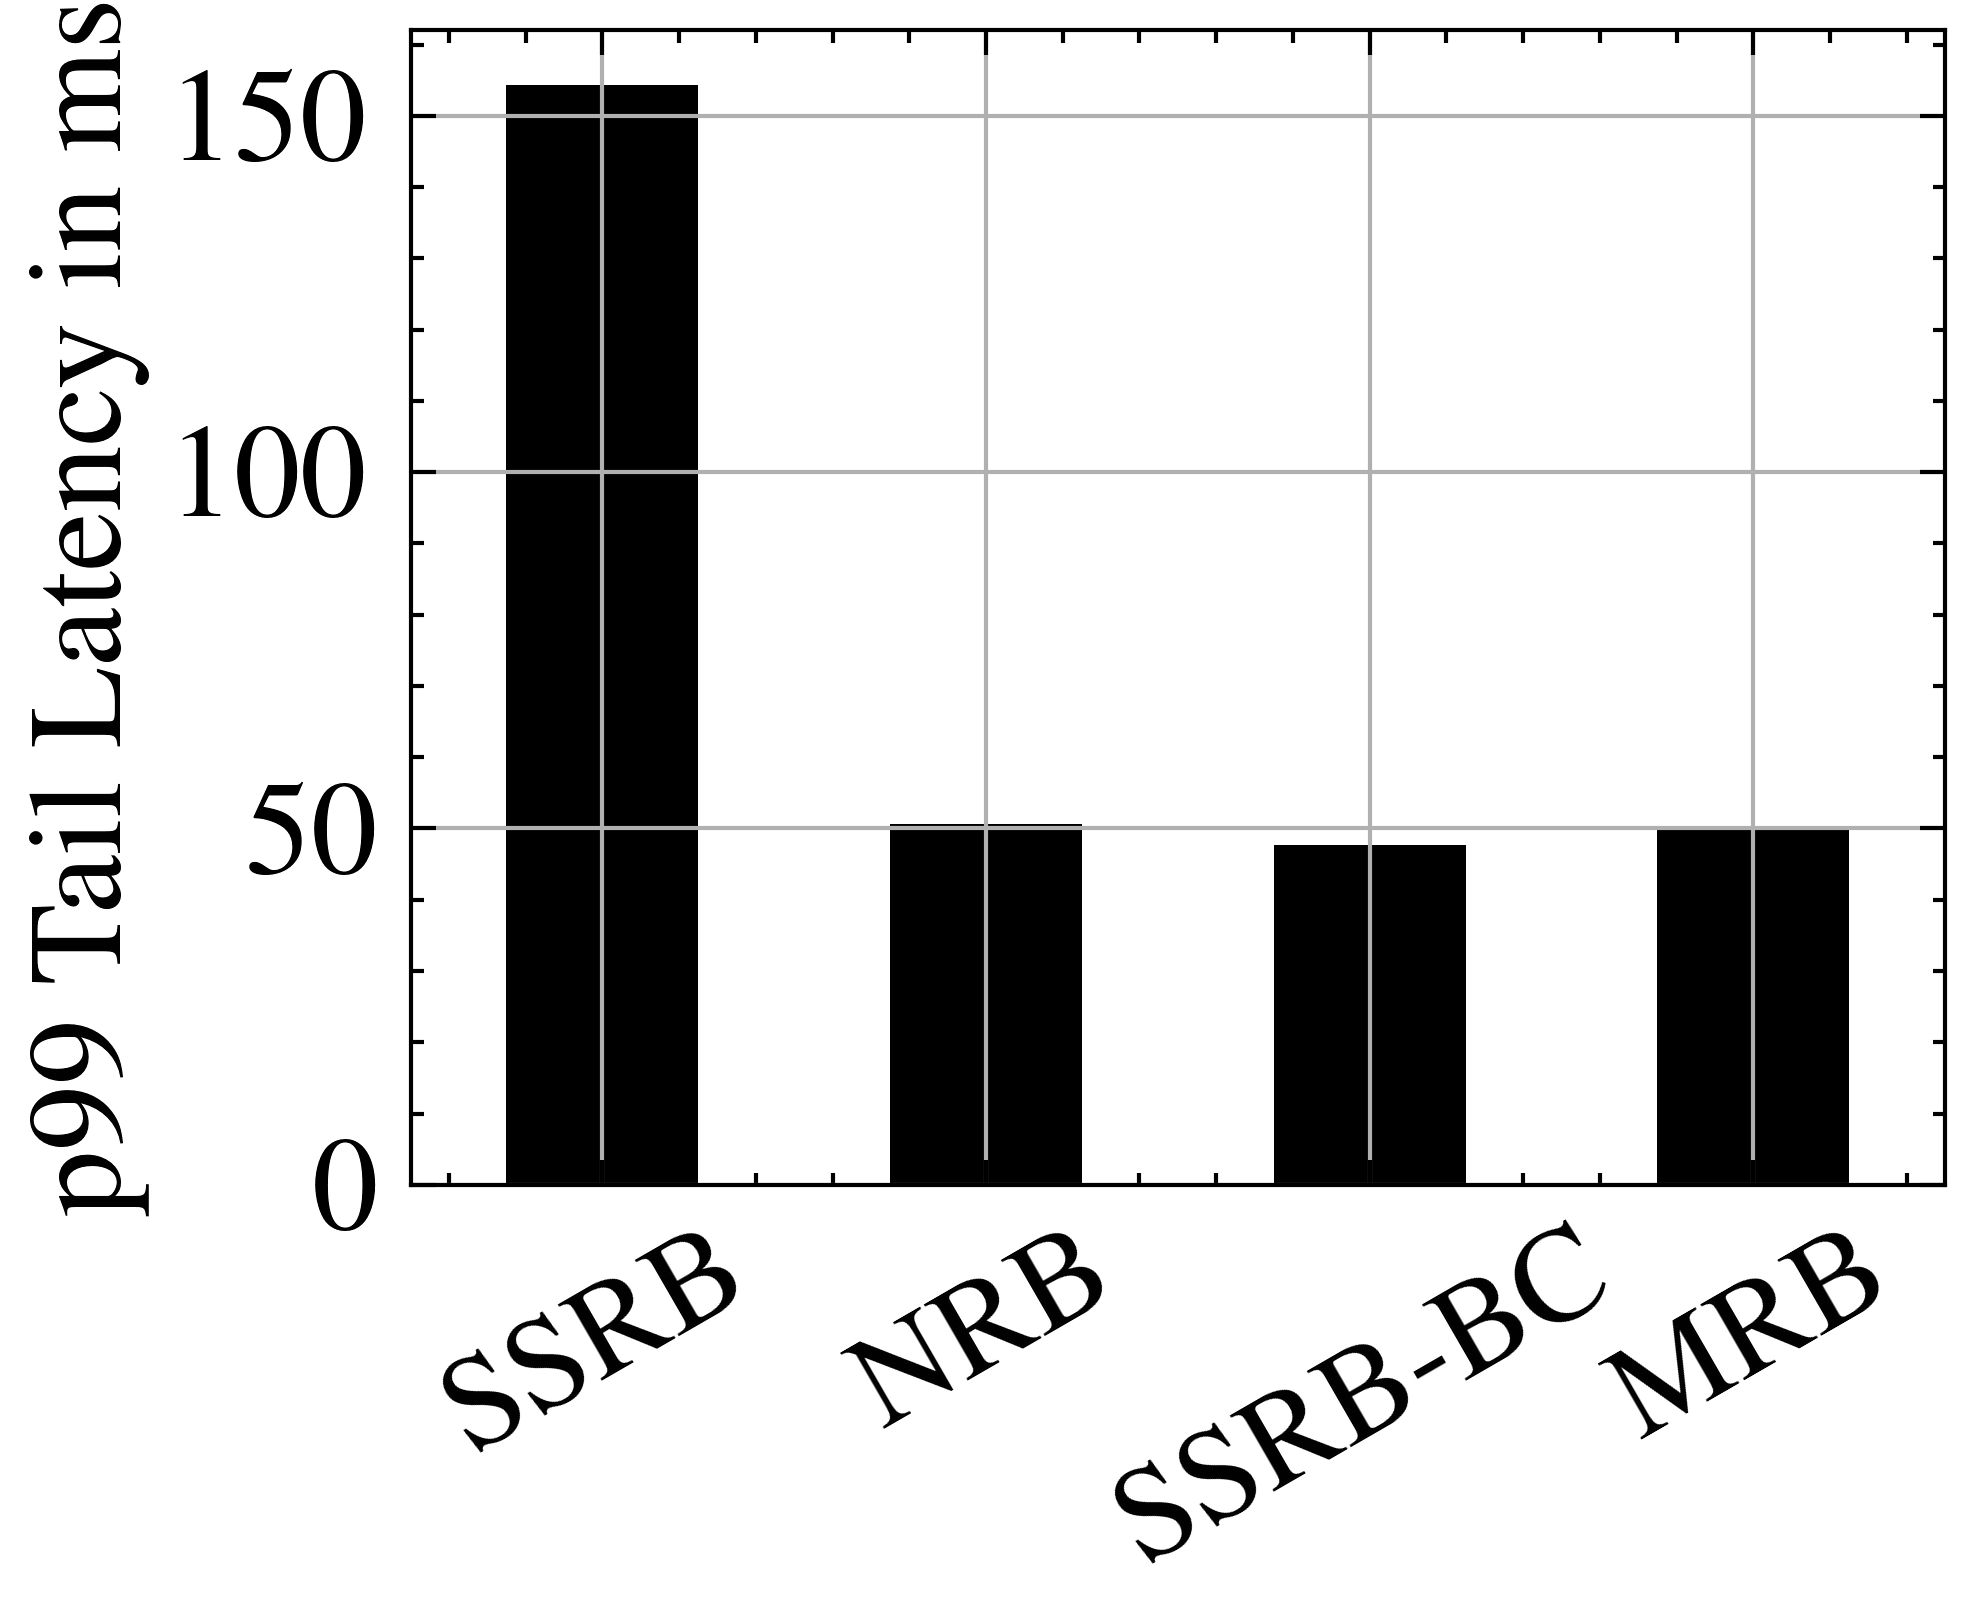

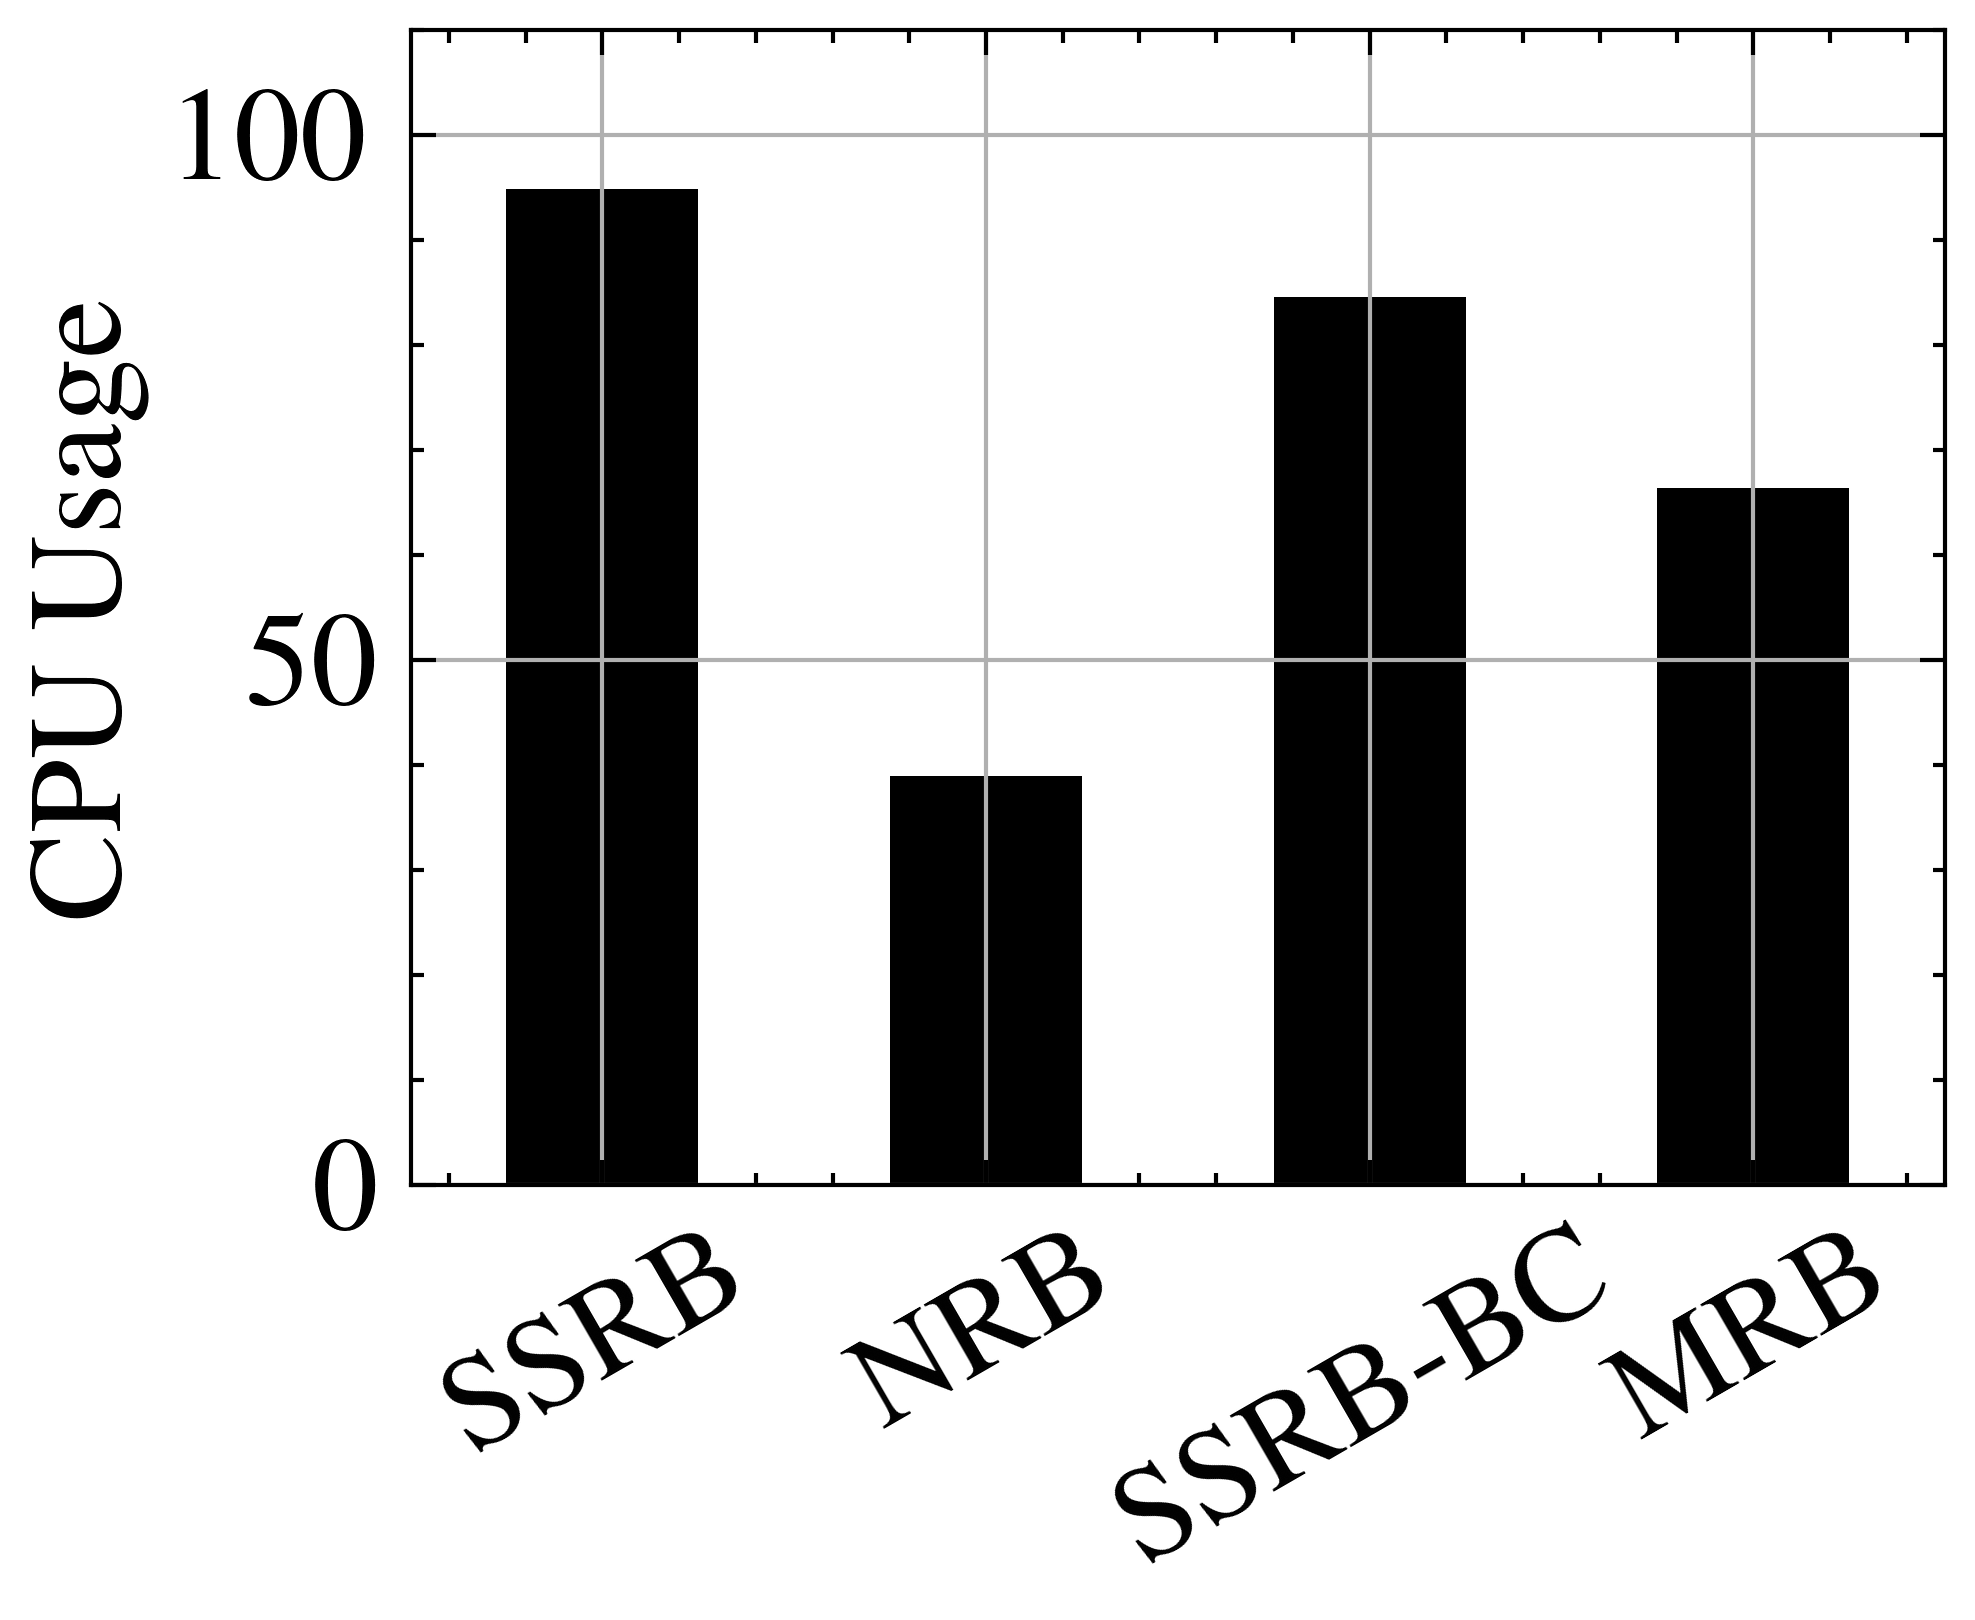

In [96]:
with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    df.plot.bar(x='variant', y='throughput', legend=None, grid=True,
               xlabel='', ylabel="Throughput in Gbps", ylim=[0, 25])
    plt.xticks(rotation=30)
    plt.show()
    
    df.plot.bar(x='variant', y='latency', legend=None, grid=True,
               xlabel='', ylabel='p99 Tail Latency in ms', ylim=None)
    plt.xticks(rotation=30)
    plt.show()
    
    df.plot.bar(x='variant', y='cpu', legend=None, grid=True,
               xlabel='', ylabel='CPU Usage', ylim=[0, 110])
    plt.xticks(rotation=30)
    plt.show()

In [97]:
df_batch.columns

Index(['throughput', 'latency', 'cpu', 'num_pids', 'decrypt_worker',
       'decrypt_packet', 'spinlock', 'cache_miss', 'cache_ops',
       'context_switch', 'migrations', 'faults', 'l1_miss', 'l1_ops',
       'llc_miss', 'llc_ops', 'start', 'end', 'batch', 'duration',
       'cache_miss_ratio', 'l1_ratio', 'llc_ratio', 'migrations/s', 'cs/s',
       'faults/s', 'variant'],
      dtype='object')

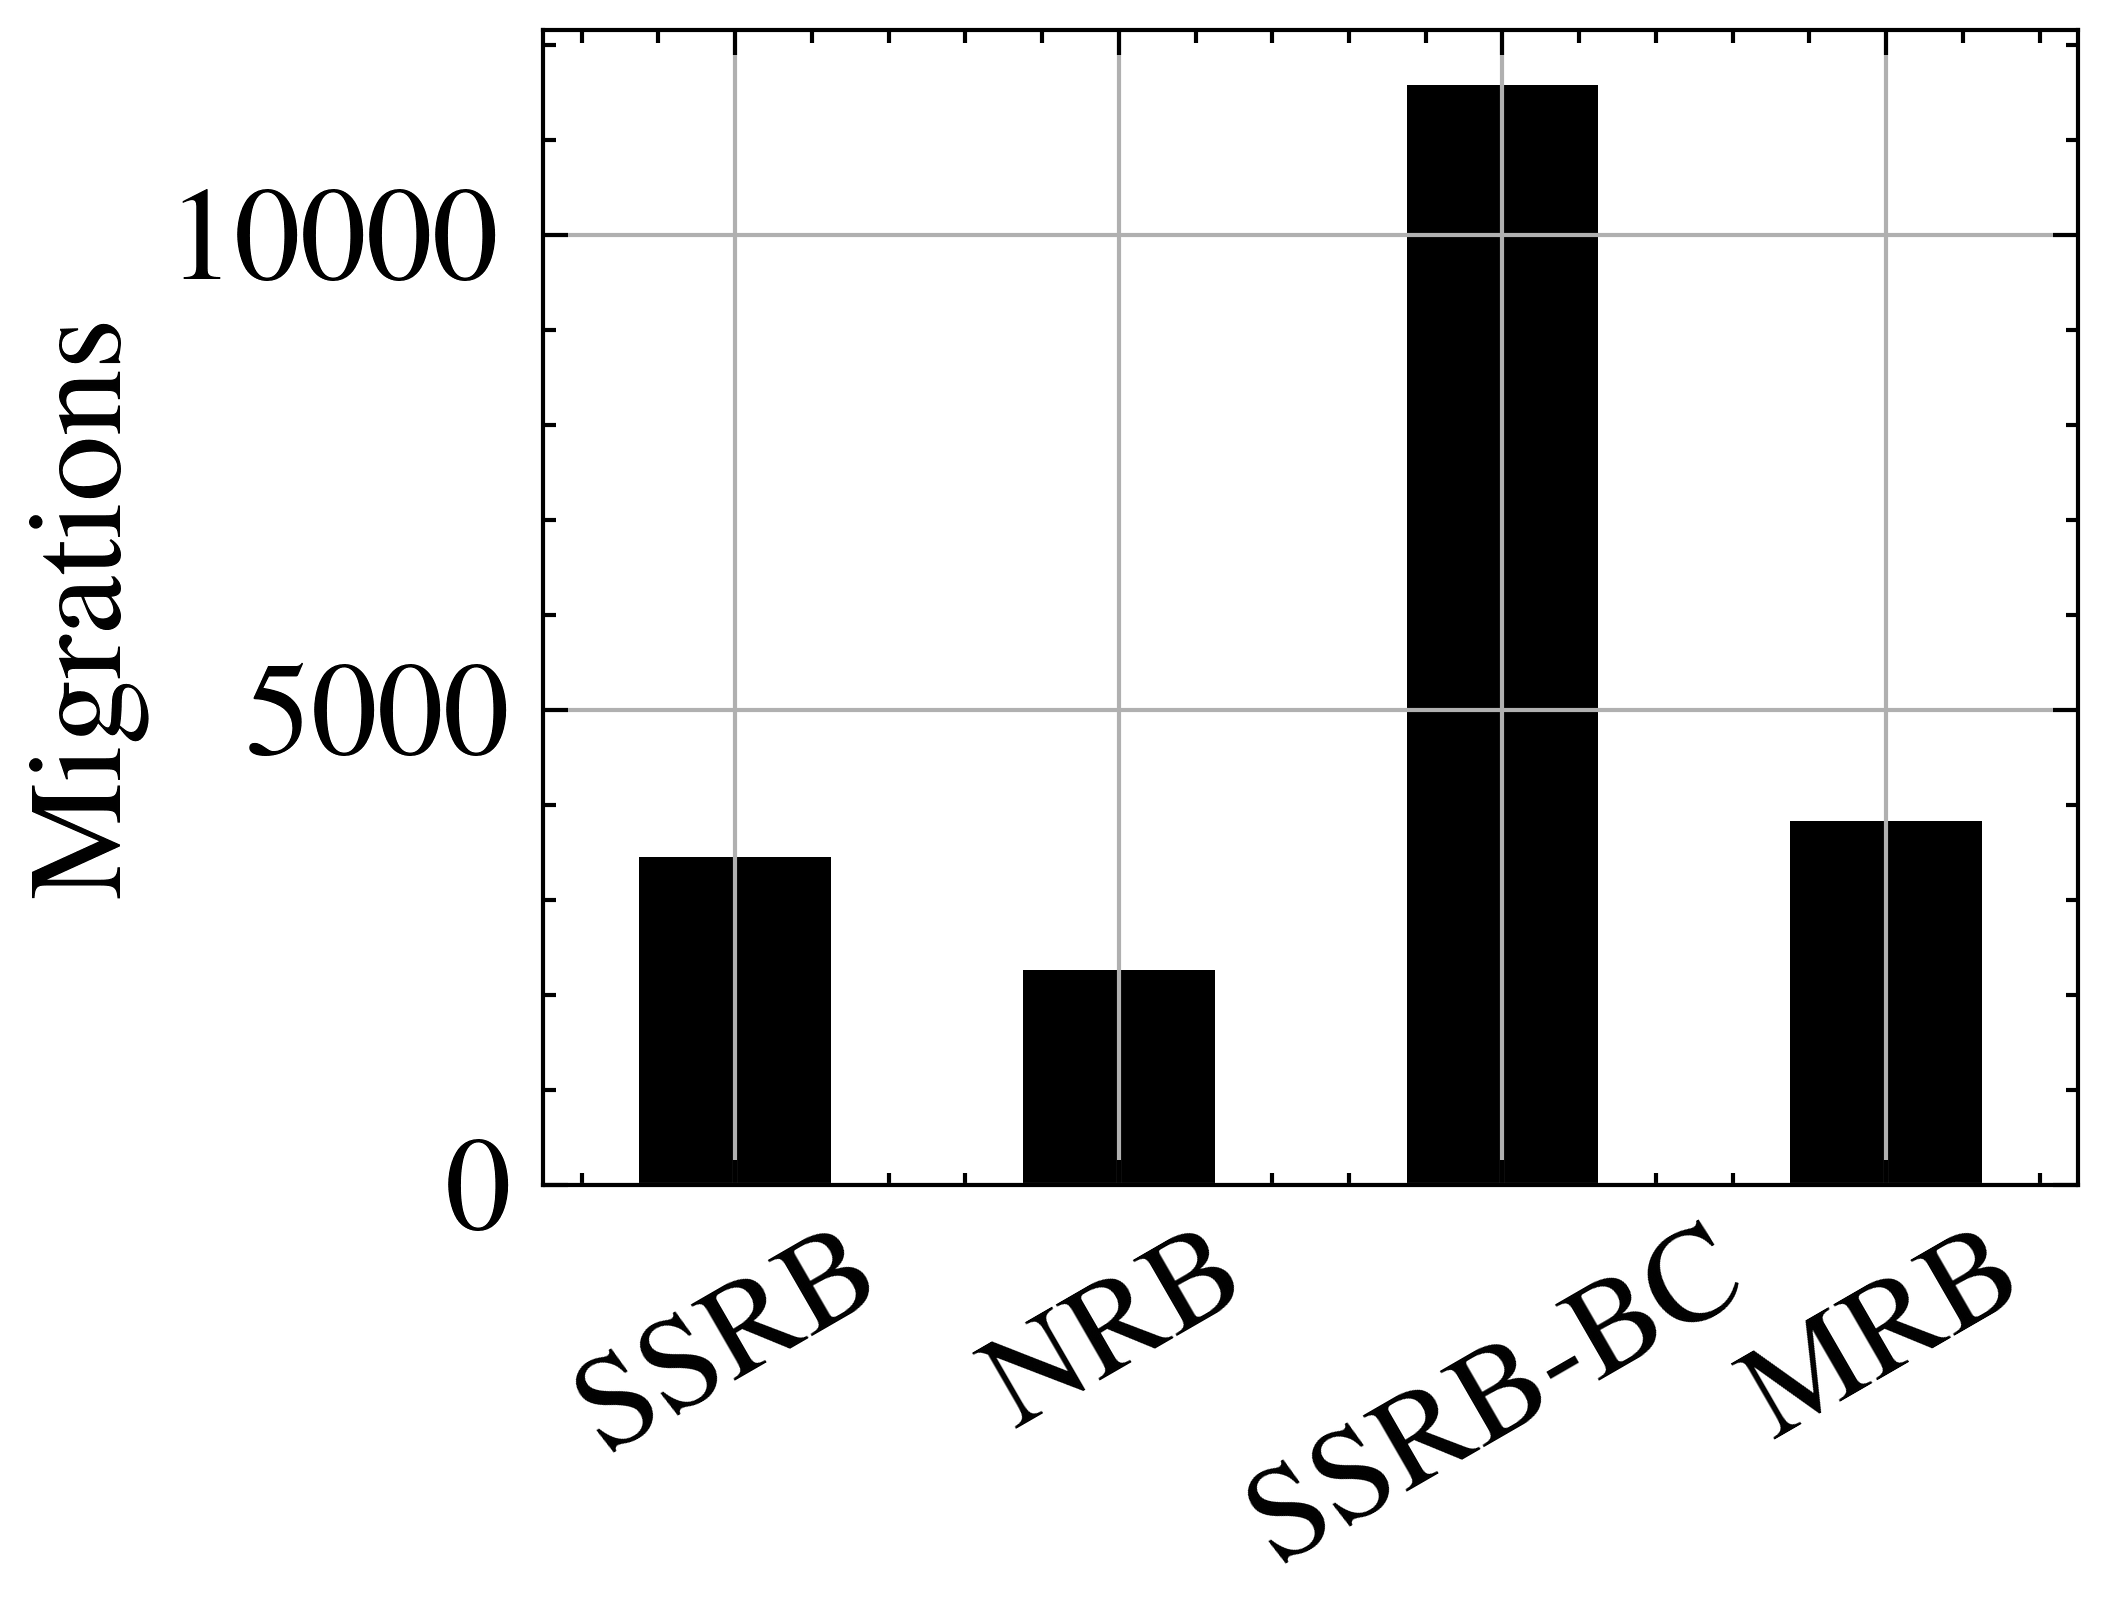

In [106]:
y = "migrations"
ylabel = "Migrations"

with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    df.plot.bar(x='variant', y=y, legend=None, grid=True,
               xlabel='', ylabel=ylabel, ylim=None)
    plt.xticks(rotation=30)
    plt.show()

In [123]:
y = 'migrations'
baseline = df[y].iloc[0]
df[f'normalized_{y}'] = df[y] / baseline

In [124]:
y = 'cs/s'
baseline = df[y].iloc[0]
df[f'normalized_{y}'] = df[y] / baseline

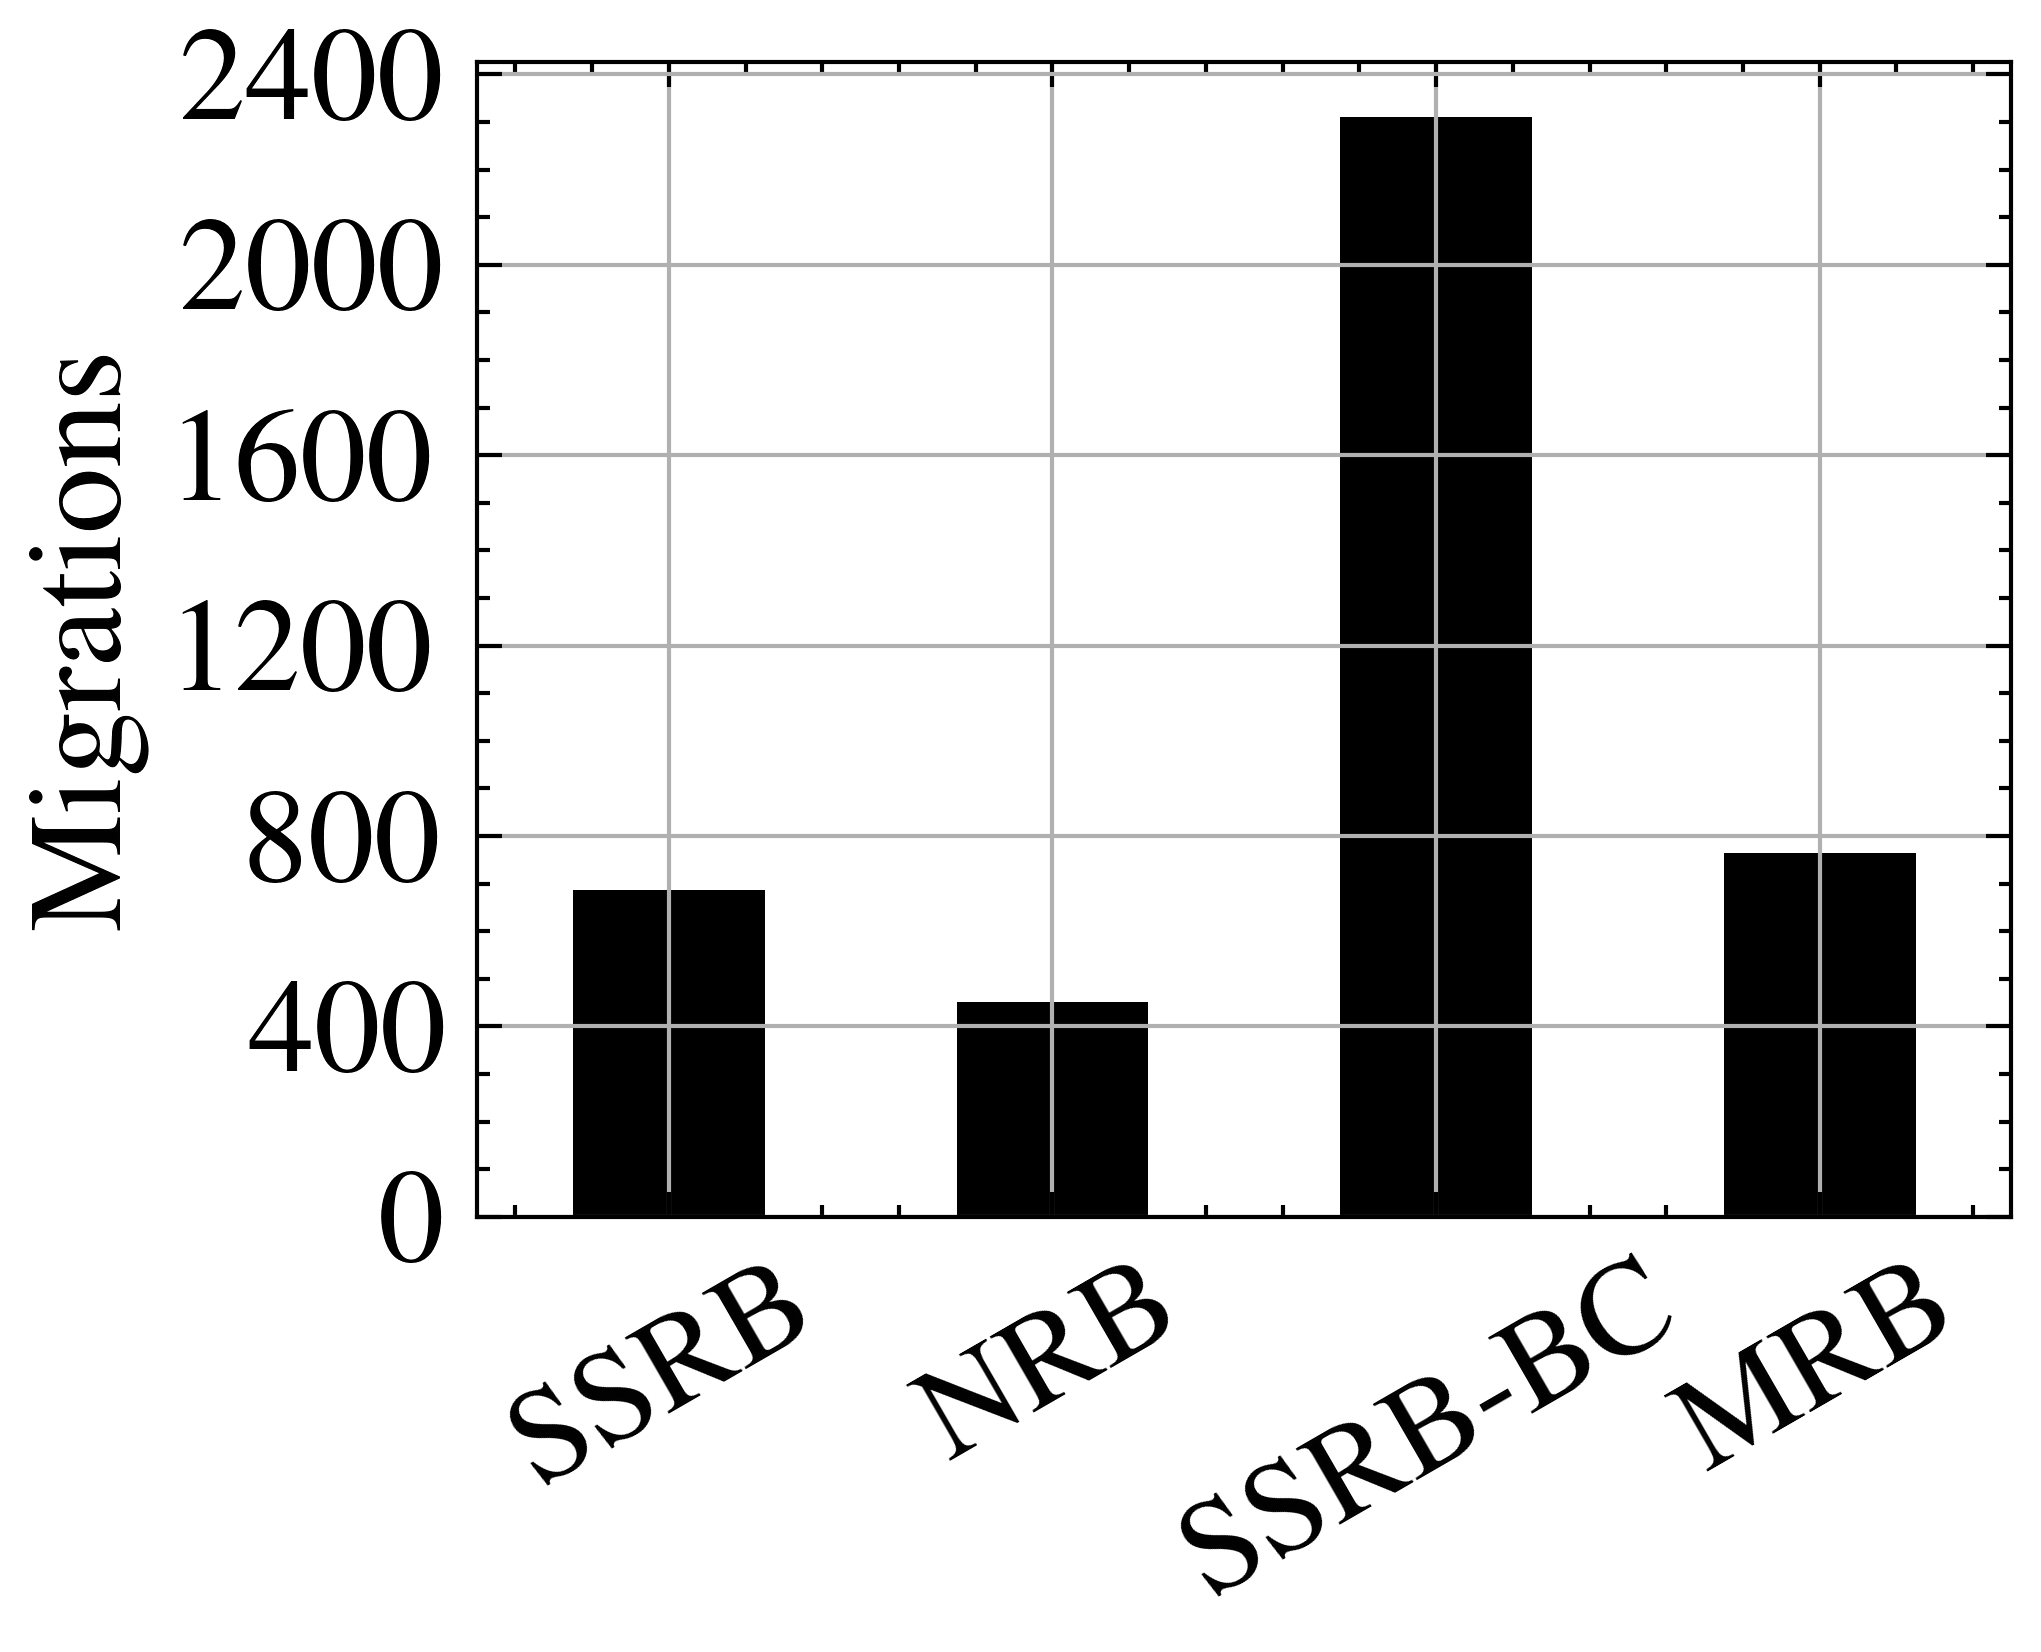

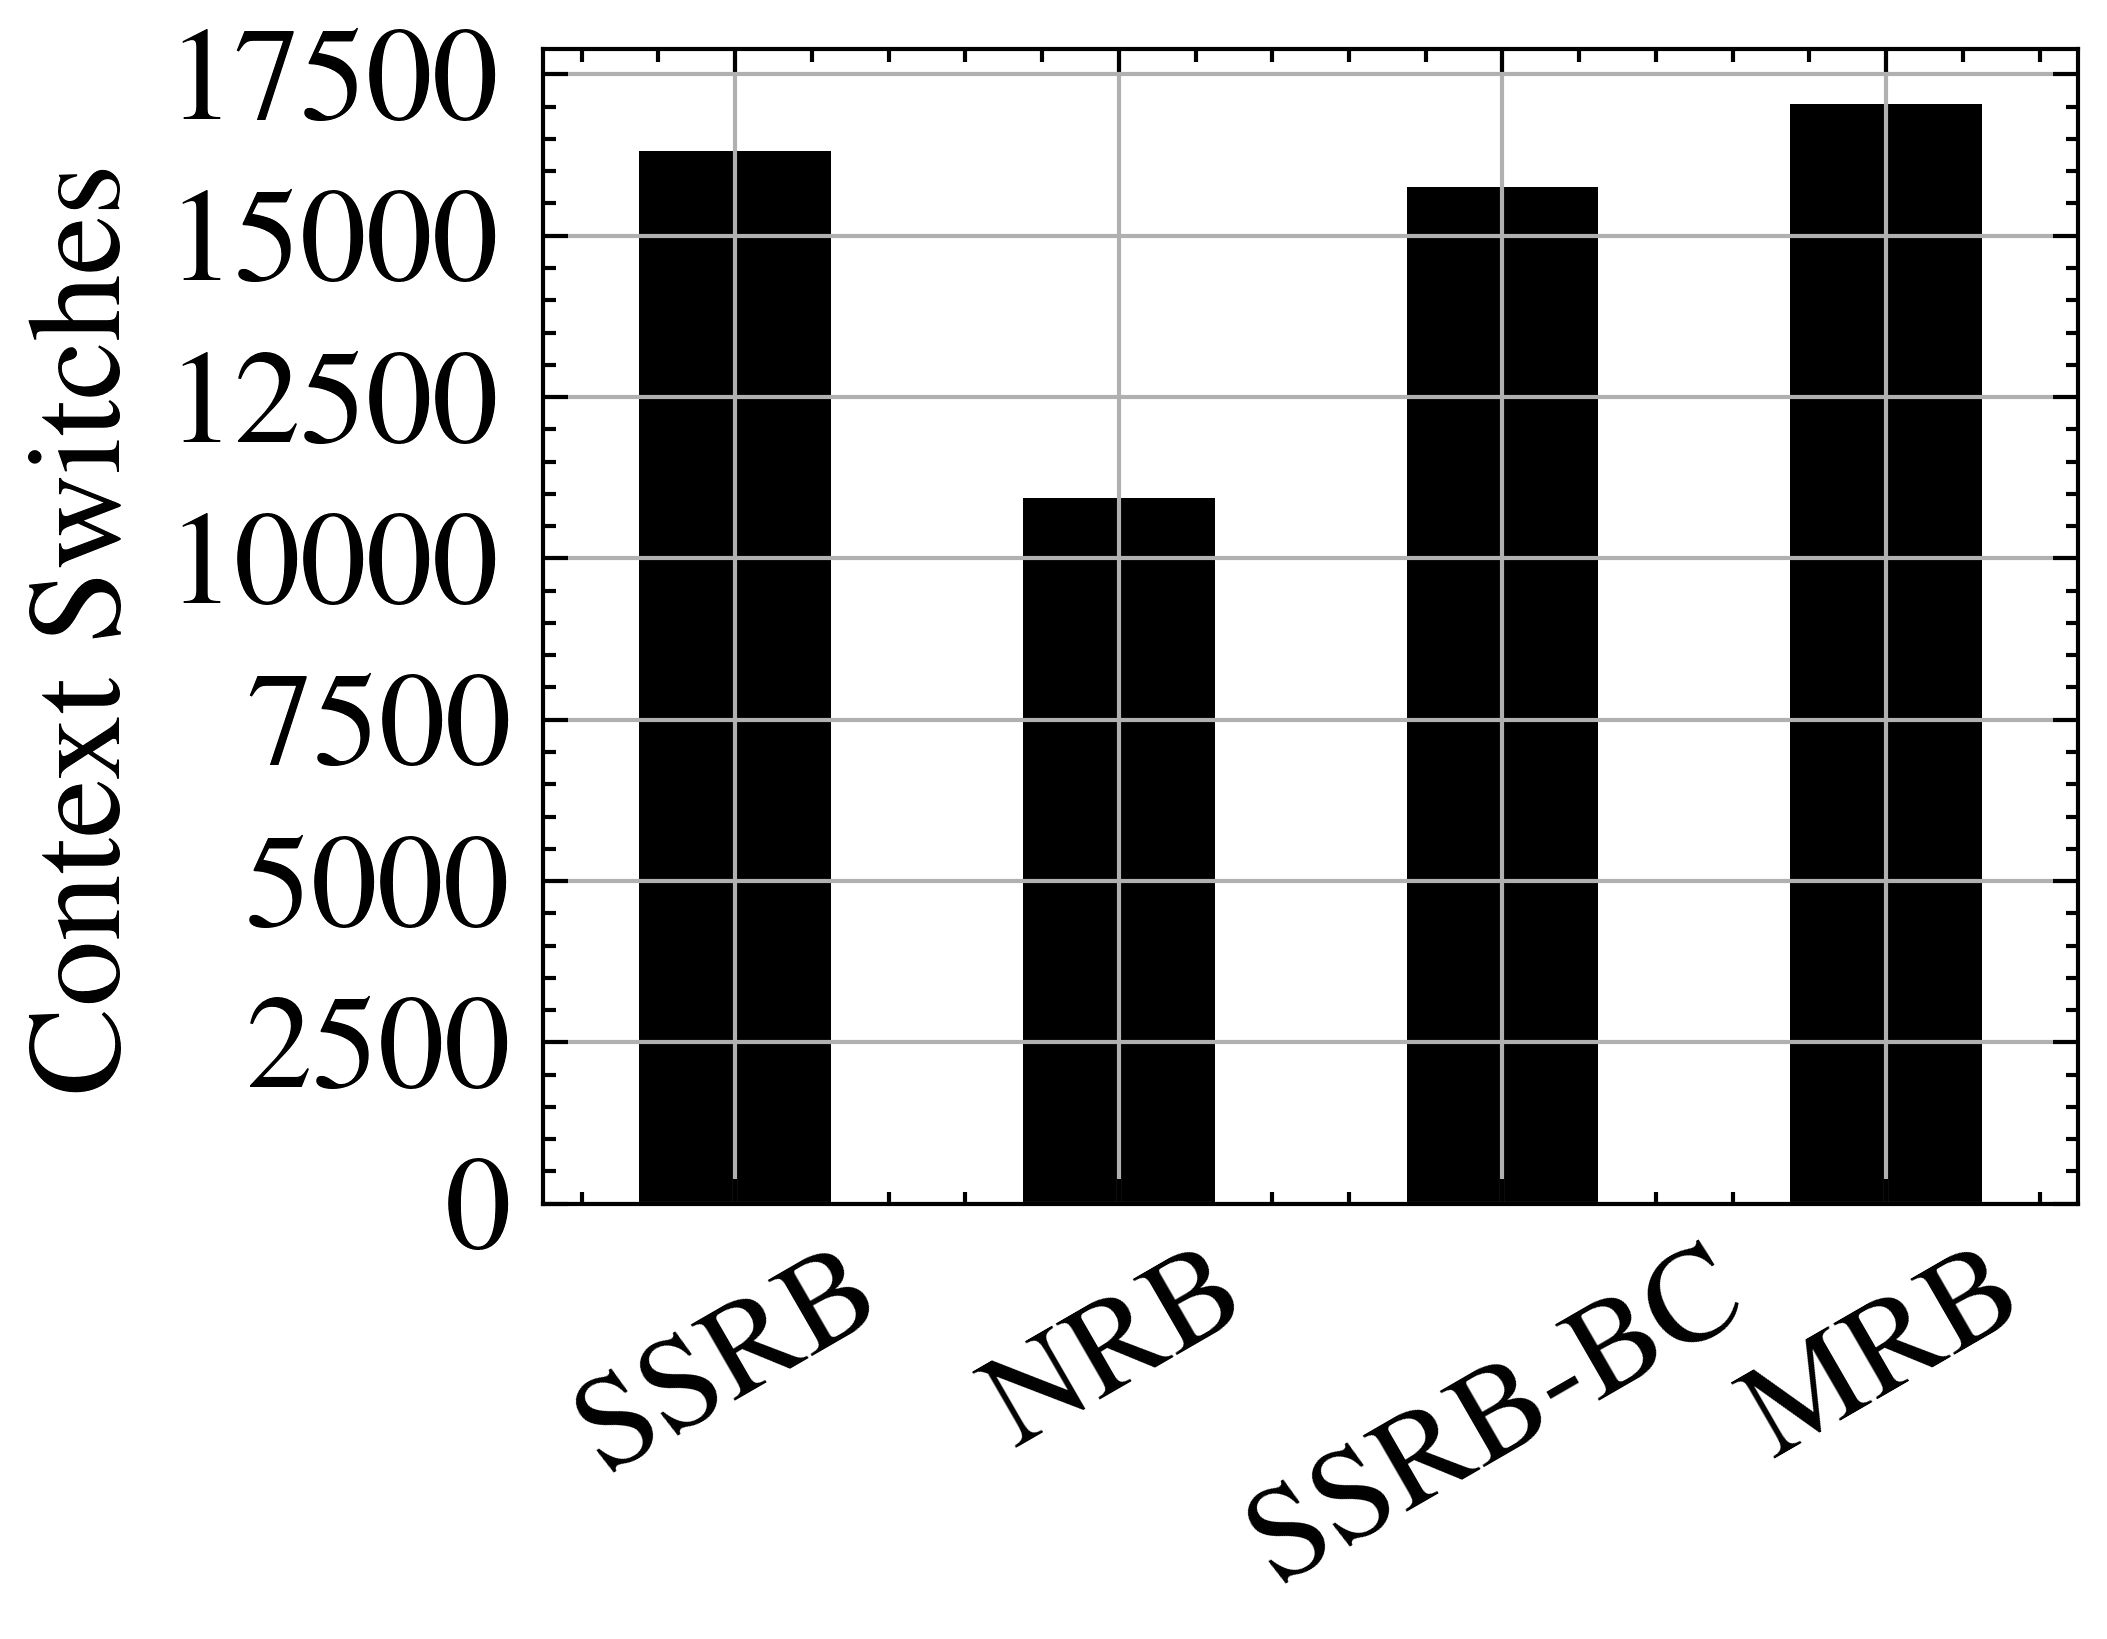

In [129]:
y = "migrations/s"
ylabel = "Migrations"

with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    ax = df.plot.bar(x='variant', y=y, legend=None, grid=True,
               xlabel='', ylabel=ylabel, ylim=None)
    plt.xticks(rotation=30)
    ax.yaxis.set_major_locator(mp.ticker.MaxNLocator(8))
    plt.show()
    
y = "cs/s"
ylabel = "Context Switches"

with plt.style.context(['science', 'ieee']):
    update_fontsize(16)
    ax = df.plot.bar(x='variant', y=y, legend=None, grid=True,
               xlabel='', ylabel=ylabel, ylim=None)
    plt.xticks(rotation=30)
    ax.yaxis.set_major_locator(mp.ticker.MaxNLocator(8))
    plt.show()